In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_all = pd.read_pickle('data.pickle')
# 初始化列为 float 类型
df_all['hour_likeCount'] = 0.0
df_all['hour_watchCount'] = 0.0

# 创建布尔索引，标识 live_time_last 不为 0 的行，避免出现0而得到无限大的数值
valid_indices = df_all['live_time_last'] != 0

# 使用布尔索引和向量化操作计算 hour_watchCount 和 hour_likeCount
df_all.loc[valid_indices, 'hour_watchCount'] = (df_all.loc[valid_indices, 'watchCount'] / df_all.loc[valid_indices, 'live_time_last']) * 3600
df_all.loc[valid_indices, 'hour_likeCount'] = (df_all.loc[valid_indices, 'likeCount'] / df_all.loc[valid_indices, 'live_time_last']) * 3600

# 输出平均值
print(df_all['hour_likeCount'].mean(), df_all['hour_watchCount'].mean())

346.223123004971 674.5854626903632


In [3]:
for column in df_all.columns:
    # 空值
    null_count = df_all[column].isnull().sum()

    # 检查字段类型是否为数值型
    if pd.api.types.is_numeric_dtype(df_all[column]):
        # 最大值
        max_value = df_all[column].max()
        
        # 最小值
        min_value = df_all[column].min()
        
        # 平均值
        mean_value = df_all[column].mean()
        
        # 打印字段信息
        print(f"字段名: {column}")
        print(f"空值数量: {null_count}")
        print(f"最大值: {max_value}")
        print(f"最小值: {min_value}")
        print(f"平均值: {mean_value}")
        print(f'字段类型：{type(column)}')
        print()
    else:
        print(f"字段名: {column}")
        print(f"空值数量: {null_count}")
        print("字段不是数值型，无法计算最大值、最小值和平均值")
        print(f'字段类型：{type(column)}')
        print()

字段名: liveId
空值数量: 0
字段不是数值型，无法计算最大值、最小值和平均值
字段类型：<class 'str'>

字段名: isFinish
空值数量: 0
最大值: True
最小值: False
平均值: 0.9999950775985819
字段类型：<class 'str'>

字段名: isFull
空值数量: 0
最大值: True
最小值: False
平均值: 0.938876695690376
字段类型：<class 'str'>

字段名: parentArea
空值数量: 0
字段不是数值型，无法计算最大值、最小值和平均值
字段类型：<class 'str'>

字段名: area
空值数量: 0
字段不是数值型，无法计算最大值、最小值和平均值
字段类型：<class 'str'>

字段名: coverUrl
空值数量: 0
字段不是数值型，无法计算最大值、最小值和平均值
字段类型：<class 'str'>

字段名: danmakusCount
空值数量: 0
最大值: 275257
最小值: 0
平均值: 1189.399399343967
字段类型：<class 'str'>

字段名: startDate
空值数量: 0
最大值: 1715780200000
最小值: 1580867858000
平均值: 1677069047865.2517
字段类型：<class 'str'>

字段名: stopDate
空值数量: 0
最大值: 1715786365542
最小值: 1580869911000
平均值: 1677080696244.3796
字段类型：<class 'str'>

字段名: title
空值数量: 0
字段不是数值型，无法计算最大值、最小值和平均值
字段类型：<class 'str'>

字段名: totalIncome
空值数量: 0
最大值: 9210992.4
最小值: 0.0
平均值: 779.8671695022778
字段类型：<class 'str'>

字段名: watchCount
空值数量: 0
最大值: 554220
最小值: 0
平均值: 1725.0120389632684
字段类型：<class 'str'>

字段名: likeCount
空值数量: 0
最大值: 2

In [4]:
df_all['month'] = df_all['start_live_time'].dt.to_period('D').dt.to_timestamp()
# 去掉23年9月后的数据
filter_date_high = pd.to_datetime('2023-09-01')
filter_date_low = pd.to_datetime('2022-09-01')
df_all_after_timesplit = df_all[(df_all['start_live_time'] <= filter_date_high) & (df_all['start_live_time'] >= filter_date_low)]

## 发现很多异常数据：有些主播的收入过高，原因是礼物数量计数错误

解决办法

- 根据主播名分组
- 四分位检测
- zscore
- log化
- 中位数填充

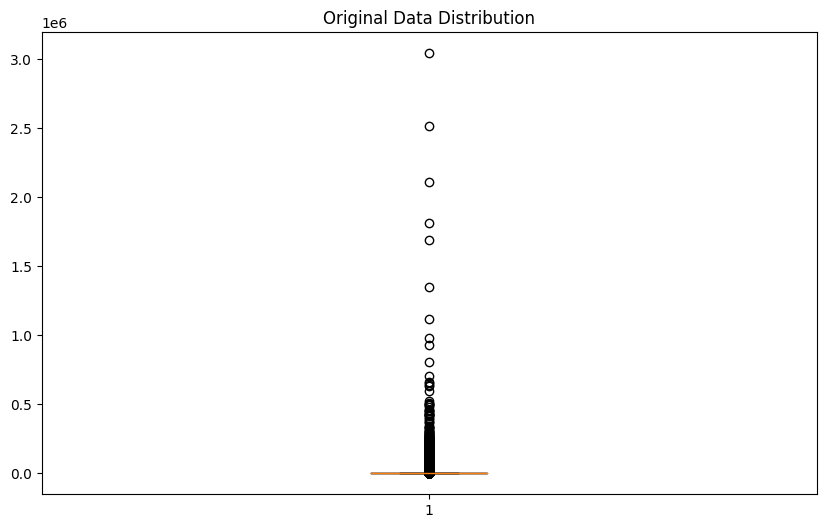

C:\Users\刘畅\AppData\Local\Temp\ipykernel_13844\1688440073.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'log_{column}'] = np.log(df[column] + 1)
C:\Users\刘畅\AppData\Local\Temp\ipykernel_13844\1688440073.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['z_score'] = np.abs(stats.zscore(df[column]))


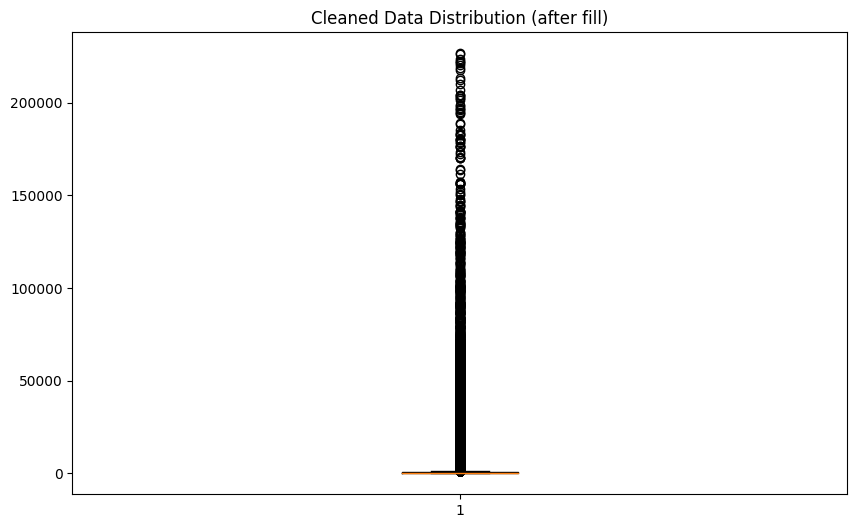

In [5]:
import pandas as pd
import numpy as np
from scipy import stats

# 定义对数据进行对数变换的函数
def log_transform(df, column):
    df[f'log_{column}'] = np.log(df[column] + 1)
    return df

# IQR方法检测异常值
def detect_outliers_iqr(df, column, outlier_thresh=3.0):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - outlier_thresh * IQR
    upper_bound = Q3 + outlier_thresh * IQR
    iqr_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return iqr_outliers

# Z-score方法检测异常值
def detect_outliers_zscore(df, column, z_thresh=3):
    df['z_score'] = np.abs(stats.zscore(df[column]))
    z_outliers = df[df['z_score'] > z_thresh]
    return z_outliers

# 结合IQR和Z-score两种方法检测异常值
def detect_outliers_combined(df, column, iqr_thresh=1.5, z_thresh=3):
    df = log_transform(df, column)
    iqr_outliers = detect_outliers_iqr(df, f'log_{column}', iqr_thresh)
    z_outliers = detect_outliers_zscore(df, f'log_{column}', z_thresh)
    
    combined_outliers_index = iqr_outliers.index.intersection(z_outliers.index)
    return df.loc[combined_outliers_index]

# 绘制数据分布图
def plot_data_distribution(df, column, title):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.boxplot(df[column])
    plt.show()

# 主方法：检测异常值并绘制分布图，补偿被删除的数据
def analyze_and_plot(data, column):
    # 原始数据分布
    plot_data_distribution(data, column, 'Original Data Distribution')

    # 检测异常值
    outliers = detect_outliers_combined(data, column)
    
    # 计算清洗后的中位数
    cleaned_data = data.drop(outliers.index)
    fill_value = cleaned_data[column].median()
    
    # 填充被删除的数据
    data.loc[outliers.index, column] = fill_value

    # 清洗后数据分布
    cleaned_data_after_fill = data
    plot_data_distribution(cleaned_data_after_fill, column, 'Cleaned Data Distribution (after fill)')

    return outliers, cleaned_data_after_fill

# 执行函数
outliers, cleaned_data = analyze_and_plot(df_all_after_timesplit, 'totalIncome')

In [6]:
# 随机打乱数据集
# cdr表示cleaned_data_ramdom
cdr = cleaned_data.sample(frac=1)

38440      22502.435
6316       17627.421
1302067    10210.940
1219298    10783.639
385423      9783.610
             ...    
494319      2393.075
1241960    10888.097
339445      8376.705
639024     11598.403
971401     16420.705
Name: live_time_last, Length: 731569, dtype: float64
38440     2023-05-25 17:18:46
6316      2023-03-01 18:25:59
1302067   2022-09-15 18:59:49
1219298   2022-09-16 21:59:36
385423    2023-01-30 18:30:19
                  ...        
494319    2022-12-24 23:15:46
1241960   2023-04-05 09:00:23
339445    2022-12-16 21:57:04
639024    2023-07-14 01:00:52
971401    2023-04-30 18:40:37
Name: start_live_time, Length: 731569, dtype: datetime64[ns]
38440     2023-05-25 23:33:48.435
6316      2023-03-01 23:19:46.421
1302067   2022-09-15 21:49:59.940
1219298   2022-09-17 00:59:19.639
385423    2023-01-30 21:13:22.610
                    ...          
494319    2022-12-24 23:55:39.075
1241960   2023-04-05 12:01:51.097
339445    2022-12-17 00:16:40.705
639024    2023-07-1

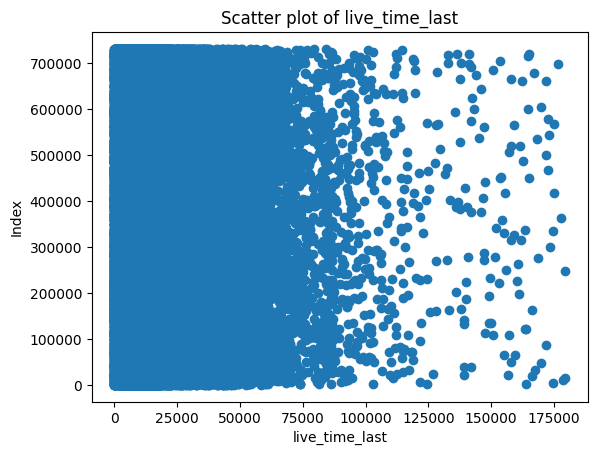

In [7]:
print(cdr['live_time_last'])
print(cdr['start_live_time'])
print(cdr['stop_live_time'])
import matplotlib.pyplot as plt
plt.scatter(cdr['live_time_last'], range(len(cdr)))
plt.ylabel('Index')
plt.xlabel('live_time_last')
plt.title('Scatter plot of '+'live_time_last')
plt.show()

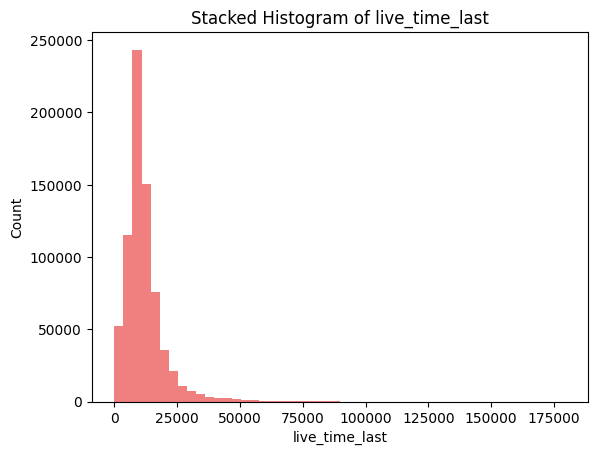

In [8]:
import matplotlib.pyplot as plt

plt.hist(cdr['live_time_last'], bins = 50, stacked=True, color='lightcoral')
plt.xlabel('live_time_last')
plt.ylabel('Count')
plt.title('Stacked Histogram of '+'live_time_last')
plt.show()

In [9]:
max_row = df_all.loc[df_all['live_time_last'].idxmax()]
print(max_row)

liveId                                       b41e2dfb-38ef-44b2-961c-dd418c6740d0
isFinish                                                                     True
isFull                                                                       True
parentArea                                                                   未知分区
area                                                                         未知分区
coverUrl                        https://i0.hdslb.com/bfs/live/new_room_cover/a...
danmakusCount                                                                1086
startDate                                                           1607500025000
stopDate                                                            1607679948000
title                                                                      =w= 惬意
totalIncome                                                                 14.56
watchCount                                                                    163
likeCount       

然而不可思议的是这个直播了将近五十个小时的数据居然不是异常值

<img src="https://p1.meituan.net/csc/73979ac50715ef6c47e9952f9f6b925a5275328.png" width="1280" height="700">

（弹幕数据也是可查的）https://laplace.live/stats/2362016/b41e2dfb-38ef-44b2-961c-dd418c6740d0

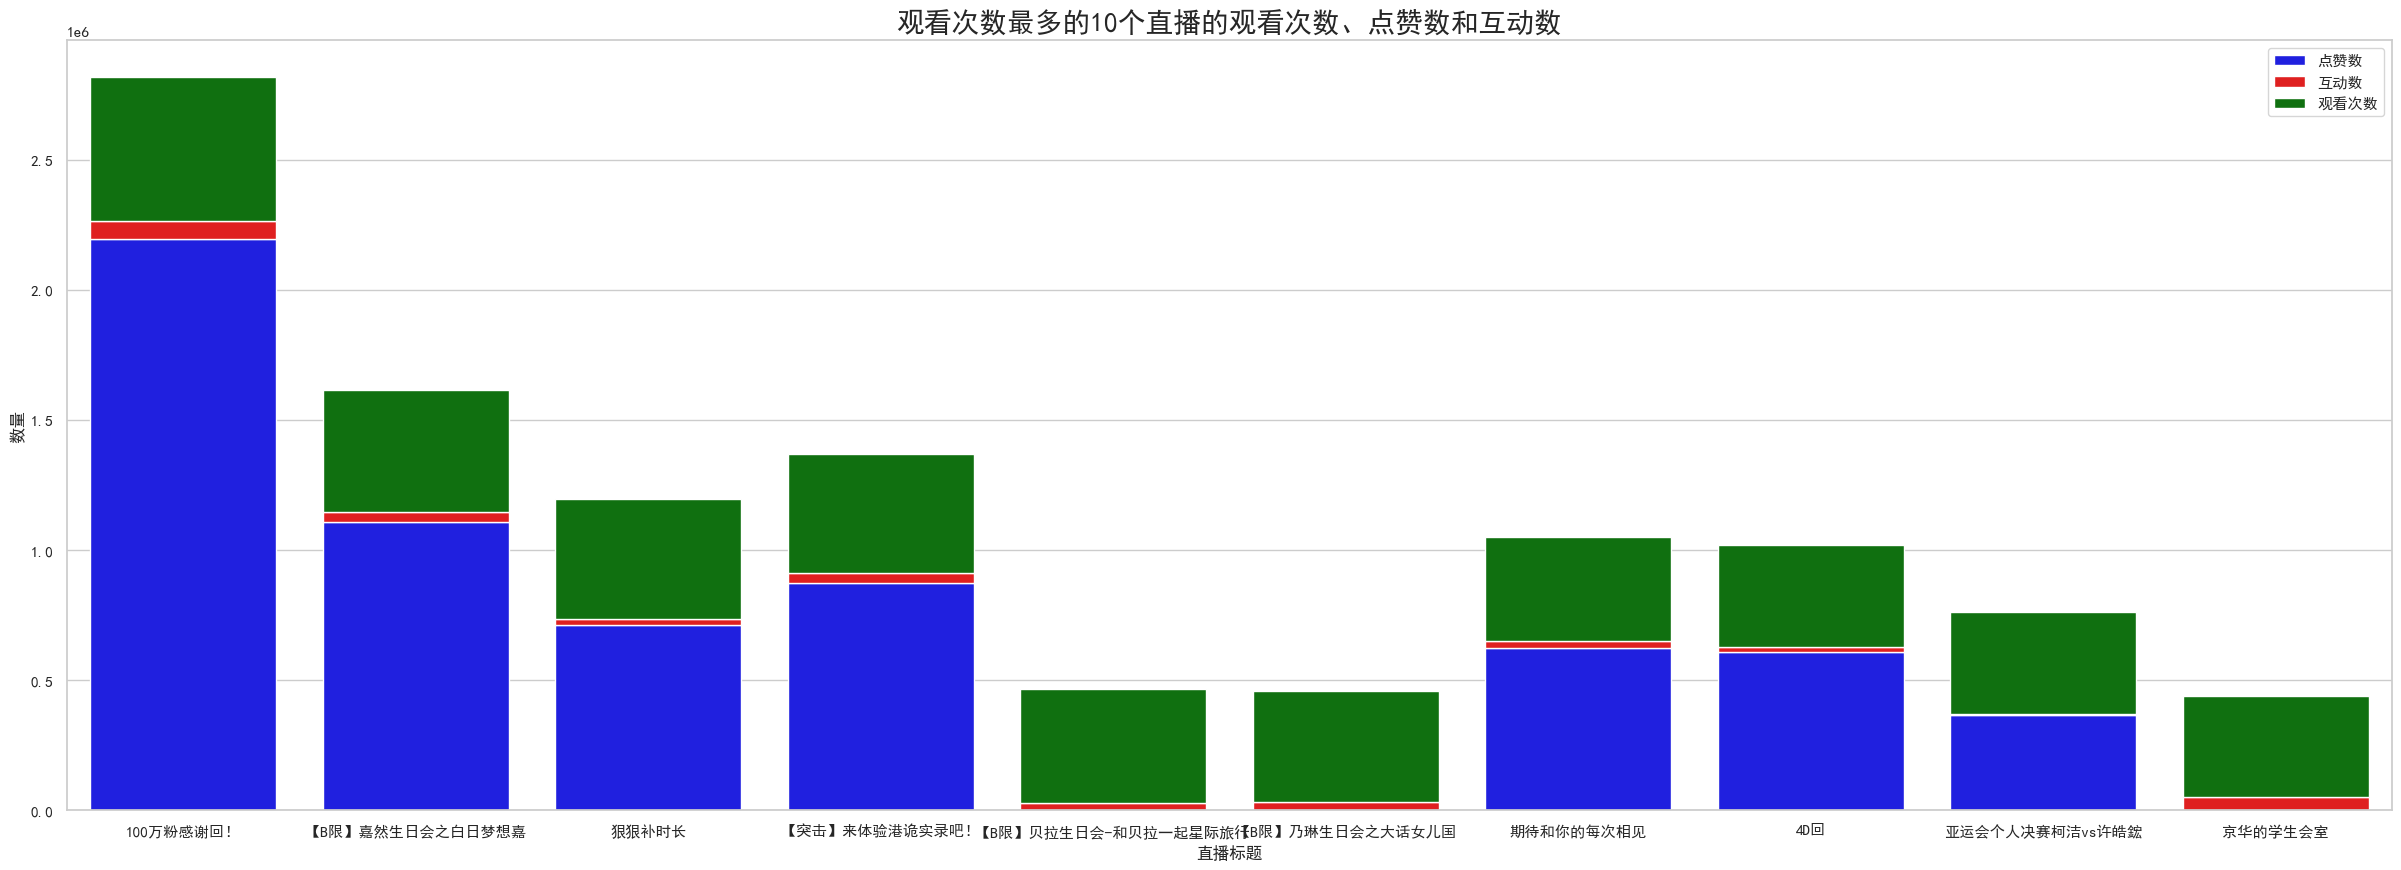

In [10]:
import seaborn as sns

# 创建一个新的Dataframe
data = {'watchCount': [554220, 470168, 460906, 455222, 439796, 428792, 402579, 394542, 391258, 385719],
        'likeCount': [2195076, 1107738, 711368, 875781, 0, 0, 623268, 610691, 368025, 0],
        'interactionCount': [68146, 37063, 24083, 37911, 28412, 31417, 25889, 15556, 3664, 52309],
        'title': ['100万粉感谢回！', '【B限】嘉然生日会之白日梦想嘉', '狠狠补时长', '【突击】来体验港诡实录吧！',
                  '【B限】贝拉生日会-和贝拉一起星际旅行', '【B限】乃琳生日会之大话女儿国', '期待和你的每次相见', '4D回',
                  '亚运会个人决赛柯洁vs许皓鋐', '京华的学生会室']}
df = pd.DataFrame(data)

# 设置风格
sns.set_theme(style='whitegrid')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 开始绘图
plt.figure(figsize=(30, 10))
plt.title('观看次数最多的10个直播的观看次数、点赞数和互动数', fontsize=20)

# 创建堆叠的条形图
sns.barplot(x='title', y='likeCount', data=df, color='blue', label='点赞数')
sns.barplot(x='title', y='interactionCount', data=df, color='red', bottom = df.likeCount, label='互动数')
sns.barplot(x='title', y='watchCount', data=df, color='green', bottom = df.likeCount + df.interactionCount, label='观看次数')

# 设置图例和标签
plt.legend()
plt.xlabel('直播标题')
plt.ylabel('数量')
plt.show()

In [11]:
grouped_df = cdr.groupby('channel_uName')[['watchCount', 'likeCount', 'interactionCount', 'totalIncome']]
grouped_df_sum = grouped_df.sum()
grouped_df_sum = grouped_df_sum.reset_index()

sorted_by_watchCount = grouped_df_sum.sort_values(by='watchCount', ascending=False)
sorted_by_likeCount = grouped_df_sum.sort_values(by='likeCount', ascending=False)
sorted_by_interactionCount = grouped_df_sum.sort_values(by='interactionCount', ascending=False)
sorted_by_totalIncome = grouped_df_sum.sort_values(by='totalIncome', ascending=False)

print('观看数排行')
print(sorted_by_watchCount.head(20))
print()
print('点赞数排行')
print(sorted_by_likeCount.head(20))
print()
print('互动数排行')
print(sorted_by_interactionCount.head(20))
print()
print('收益排行')
print(sorted_by_totalIncome.head(20))

观看数排行
       channel_uName  watchCount  likeCount  interactionCount  totalIncome
67           Asaki大人    62756955   50642746           5271496    6990651.4
96              C酱です    56062194   13466812           4654911    3409497.7
2667            永雏塔菲    28564760    8085451           2082525    2070374.9
3241   眞白花音_Official    27960934   16337503           2161242    3074388.0
343           hanser    21894471   29778963           1931384    1206690.3
4303        阿梓从小就很可爱    19921140    4711862           1863785    2446835.3
380        shourei小N    17861366    9469728            963827     875190.8
2890       烛灵儿Hikari    17245130    8045256           1016704    3419293.4
468        七海Nana7mi    15562459    3281937           1130156    3207856.8
4317           阿萨Aza    13950521   33432910           2672075    6695969.8
4559  鲸鱼娘西丝特official    13163291   14981911            909080     952260.8
2283            月隐空夜    12690620    1792517            646509     711149.2
4391    雫るる_Officia

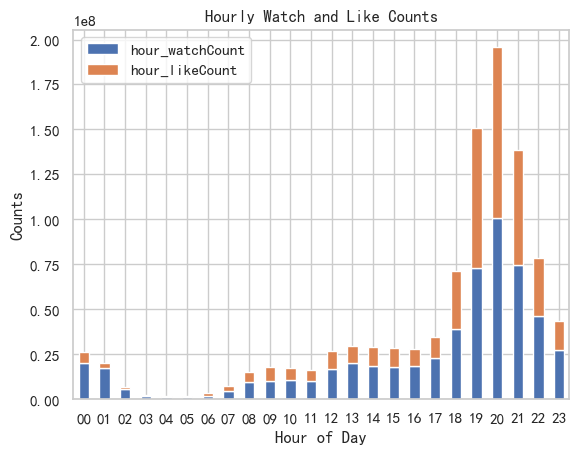

In [12]:
cdr['start_live_time'] = pd.to_datetime(cdr['start_live_time'])
cdr['stop_live_time'] = pd.to_datetime(cdr['stop_live_time'])

# 提取小时部分
cdr['hour'] = cdr['start_live_time'].dt.strftime('%H')

# 使用小时进行分组，并计算hour_watchCount和hour_likeCount的总值
hourly_totals = cdr.groupby('hour').agg({'hour_watchCount': 'sum', 'hour_likeCount': 'sum'})
hourly_totals.plot(kind='bar', stacked=True)
# 添加标题和标签
plt.title('Hourly Watch and Like Counts')
plt.xlabel('Hour of Day')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.show()

In [13]:
grouped = cdr.groupby(['channel_uId', 'channel_uName']).agg({'totalIncome': 'sum', 'title': 'count'}).reset_index()

# 计算每个主播每次直播的平均收益
grouped['avgIncomePerLive'] = grouped['totalIncome'] / grouped['title']
grouped.rename(columns={'title': 'live_times'}, inplace=True)
grouped_sorted = grouped.sort_values(by='avgIncomePerLive', ascending=False)
print('——————————直播效益前二十————————————')
print(grouped_sorted.head(20))

——————————直播效益前二十————————————
           channel_uId    channel_uName  totalIncome  live_times   
3692        1775966996  Vox_EN_Official     537374.0           5  \
3481        1544125954   Mysta_Official     249274.1           4   
3539        1601895109   shoto_official     350750.2          11   
2508         480745939           罗伊_Roi    1818871.0          58   
3236        1281805827  Fulgur_Official     197604.4           8   
2882         672353429           贝拉kira    1662730.7          69   
2880         672342685          乃琳Queen    1509153.9          71   
4621  3494357252442916     RO姬_Official     634757.8          32   
2507         480680646            阿萨Aza    6695969.8         353   
2879         672328094          嘉然今天吃什么    1378473.7          77   
1960         194484313          Asaki大人    6990651.4         393   
2881         672346917            向晚大魔王    1146944.9          68   
1846          99407665         江苹果Ringo    1054843.5          69   
1342          1814

<Axes: xlabel='parentArea'>

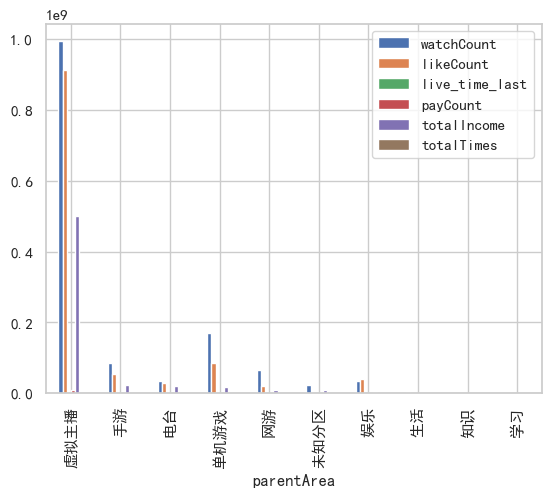

In [14]:
grouped_area = cdr.groupby('parentArea').agg({'watchCount': 'sum', 'likeCount': 'sum', 'live_time_last': 'mean', 'payCount': 'sum', 'totalIncome': 'sum', 'channel_roomId': 'count'})
grouped_area.rename(columns={'channel_roomId': 'totalTimes'}, inplace=True)
grouped_area_sorted = grouped_area.sort_values(by='totalIncome', ascending=False)
plt.rcParams['font.sans-serif'] = ['SimHei']
grouped_area_sorted[0:10].plot(kind='bar')

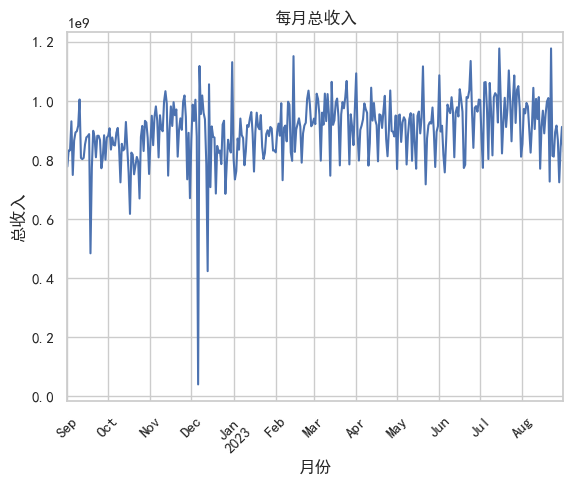

In [174]:
grouped_month = cdr.groupby('month').agg({ 'channel_totalIncome': 'sum'})

# new_grouped_sorted = new_grouped.sort_values(by = 'channel_totalIncome', ascending=False)
# print(new_grouped_sorted)
grouped_month.plot(kind = 'line', legend = False)
plt.title('每月总收入')
plt.xlabel('月份')
plt.ylabel('总收入')
plt.grid(True)
plt.xticks(rotation=45)  # 旋转横轴标签以提高可读性
plt.show()

In [175]:
print(cdr.columns)

Index(['liveId', 'isFinish', 'isFull', 'parentArea', 'area', 'coverUrl',
       'danmakusCount', 'startDate', 'stopDate', 'title', 'totalIncome',
       'watchCount', 'likeCount', 'payCount', 'interactionCount',
       'maxOnlineCount', 'code', 'message', 'channel_uId', 'channel_uName',
       'channel_roomId', 'channel_faceUrl', 'channel_frameUrl',
       'channel_isLiving', 'channel_title', 'channel_tags',
       'channel_lastLiveDate', 'channel_lastLiveDanmakuCount',
       'channel_totalDanmakuCount', 'channel_totalIncome',
       'channel_totalLiveCount', 'channel_totalLiveSecond', 'channel_addDate',
       'channel_commentCount', 'channel_lastLiveIncome', 'start_live_time',
       'stop_live_time', 'live_time_last', 'hour_likeCount', 'hour_watchCount',
       'month', 'log_totalIncome', 'z_score', 'hour'],
      dtype='object')


# 数据挖掘思路
## 字段解释

带-的不用管

|字段|解释|
|:--:|:--:|
|liveId|直播id|
|isFinish|-| 
|isFull|-|
|parentArea|主分区|
|area|子分区|
|coverUrl|-|
|danmakusCount|本场弹幕数|
|startDate|本场开始时间|
|stopDate|本场结束时间|
|title|本场直播标题|
|totalIncome|本场直播收入|
|watchCount|本场观看数|
|likeCount|本场点赞数（22年9月才开始记录）|
|payCount|本场礼物数|
|interactionCount|本场互动数|
|maxOnlineCount|本场最高在线人数|
|code|-|
|message|-|
|channel_uId|主播uid|
|channel_uName|主播名|
|channel_roomId|直播房间号|
|channel_faceUrl|-|
|channel_frameUrl|-|
|channel_isLiving|-|
|channel_title|频道标题|
|channel_tags|频道tag|
|channel_lastLiveDate|主播上次开播时间|
|channel_lastLiveDanmakuCount|主播上次弹幕数|
|channel_totalDanmakuCount|主播弹幕总数|
|channel_totalIncome|主播总收入|
|channel_totalLiveCount|主播总场次|
|channel_totalLiveSecond|主播总时长|
|channel_addDate|最初开播时间|
|channel_commentCount|频道总评论数|
|channel_lastLiveIncome|主播上次直播收入|
|start_live_time|本场开始时间（和上面那个格式不同）|
|stop_live_time|本场结束时间|
|live_time_last|本场时长|
|hour_likeCount|本场平均每小时点赞|
|hour_watchCount|本场平均每小时观看|
|month|本场所在年月|
|log_totalIncome|对数化的本场收入|
|z_score|-|
|hour|本场开播时间（24小时制）|

## 无监督

### 聚类算法

选一个合适（给出所有算法的结果，选一个效果好的）的聚类算法对所有数据记录聚类（算法+评价指标）。这个聚类直接聚就完了，意义只是怎么解释聚类完的结果，因为这个聚类是不带监督指标的

### 关联规则

分两步走：
- 本场数据指标的关联
- 频道/主播指标关联
（意思是要把这些分开做，因为一个主播有多场直播，不过本场数据指标可能可以考虑频道指标，这个得试试）

把非数值型的字段先二元化，再做分析

想办法指定前后项（问问gpt吧，理论上可以把除了收入之外的字段标注为输入与输出（可能要考虑加不加id），收入这样的标为仅输入）

## 带监督

### 分类算法

分类机特别多（这里包括了神经网络），但是可以根据一套标准来进行评价（f值，混淆矩阵，roc曲线和auc值）

朴素贝叶斯，KNN，决策树，逻辑回归，网上一查一大堆

先构造一个合理的监督指标y，建议复制一下上面的所有字段解释问一下gpt（可以试试多搞几个y，相当于找不同的角度，每个y做一次）

再挑X（最好不要一次放完所有字段）

### 回归

很多分类机有回归功能，比如crt这种，所以不用专门弄，但是要在分类算法里注明哪些是y用的是回归

### 文本

先弄完上面的再说吧。。。


## 聚类算法——K-means

In [229]:
# 从 cdr 中随机抽取记录
binnum = 300

cdr['Bin'] = pd.qcut(cdr['hour_watchCount'], q = binnum, duplicates='drop')
best_q_num_value = np.quantile(cdr_wc, best_q)
cdf_sorted = cdr.sort_values(by="hour_watchCount")

# 第一个分箱选全部
first_bin = cdf_sorted[cdf_sorted["hour_watchCount"] <= best_q_num_value]

[(41.519, 42.047], (7133.177, 8647.04], (13.961, 14.328], (28.852, 29.254], (48.264, 48.871], ..., (387.061, 396.902], (114.066, 115.821], (19.644, 20.0], (22.479, 22.844], (28.078, 28.467]]
Length: 298
Categories (298, interval[float64, right]): [(-0.001, 2.699] < (2.699, 3.625] < (3.625, 4.381] < (4.381, 4.997] ... (8647.04, 10994.801] < (10994.801, 15282.403] < (15282.403, 23670.979] < (23670.979, 5217620.302]]

In [231]:
# 目标值为最大值的一半
target_value = cdr["channel_totalIncome"].max() / 2
print(target_value)
cdr_wc = np.array(cdr["channel_totalIncome"])

# 初始化误差和范围
threshold = 10
lower = 0
upper = 1
best_q_num = None
best_q = None
closest_difference = float('inf')

# 二分查找法
while upper - lower > 0.000000000001:  # 使用小数精度限制查找次数
    q = (upper + lower) / 2
    q_Num = np.quantile(cdr_wc, q)
    
    difference = abs(q_Num - target_value)
    
    # 更新最佳值和范围
    if difference < closest_difference:
        closest_difference = difference
        best_q_num = q_Num
        best_q = q
    
    # 检查是否在误差范围内
    if difference <= threshold:
        break
    elif q_Num < target_value:
        lower = q
    else:
        upper = q

print(f'最佳分位数为 {1/(1-best_q)}，对应的值为 {best_q_num}')

# # 目标是最大值的一半
# target_value = cdr["hour_watchCount"].max() / 2
# cdr_wc = np.array(cdr["hour_watchCount"])

# # 初始化误差和分位数
# division_num = 1
# q = 1
# threshold = 10
# # 寻找一个合适的分位数让他接近这个目标值
# while True:
#     q_Num = np.quantile(cdr_wc, q)

#     # 如果得到的q_Num在误差内和目标值相等则停止循环
#     if abs(q_Num - target_value) <= threshold:        break
#     # 如果找不到就加一个分箱数
#     else:
#         print(q_Num)
#         division_num += 1
#         q = 1-1/division_num
# print(f'最佳分箱数为{q_Num}')

8775561.0
最佳分位数为 300.3558961946034，对应的值为 8775554.80147838


In [233]:
# 从 cdr 中随机抽取记录
binnum = 300

cdr['Bin'] = pd.qcut(cdr['channel_totalIncome'], q = binnum, duplicates='drop')

best_q_num_value = int(np.quantile(cdr_wc, best_q))
cdf_sorted = cdr.sort_values(by="channel_totalIncome")

# 第一个分箱选全部
first_bin = cdf_sorted[cdf_sorted["channel_totalIncome"] >= best_q_num_value]
first_bin_size = first_bin.shape[0]

# 获取剩余分箱的数据
remaining_bins = cdf_sorted[cdf_sorted["channel_totalIncome"] < best_q_num_value]

# 从剩余分箱中随机选择与第一个分箱相同数量的数据
remaining_sample = remaining_bins.sample(n=first_bin_size, random_state=42)

# 合并采样数据
final_sample = pd.concat([first_bin, remaining_sample])

print(final_sample)

                                       liveId  isFinish  isFull parentArea   
1194920  150ae861-0b18-4384-bbb7-195955d69215      True    True       虚拟主播  \
1194900  65cdeb12-7a77-4d01-8a4a-ca32613c0496      True    True       虚拟主播   
1194915  e395413b-850f-4a00-9417-d106fa71d299      True    True       虚拟主播   
1194911  29ced1f9-c2b9-4c32-b933-b3e188a9dfb8      True    True       虚拟主播   
1194890  a95a1da6-0709-4180-bc90-f8b6185a106e      True    True       虚拟主播   
...                                       ...       ...     ...        ...   
1207379  810fc03d-ea4f-4cf2-974f-d2320a356b7f      True    True       虚拟主播   
130567   d58b9ad6-7186-4520-8cb0-41017b3cab5d      True    True       虚拟主播   
62078    380d0474-e893-4068-9919-ddbdbb35dc21      True    True       虚拟主播   
1392834  a8619bed-40a3-43b4-9917-83b02f84c8a7      True    True       虚拟主播   
362751   b33df7d9-4706-40d5-8457-cc364582b2c4      True    True         电台   

            area                                           cove

In [234]:
# sample_cdr = cdr.sample(n=100000, random_state=42)
sample_cdr = final_sample
sample_cdr.columns

Index(['liveId', 'isFinish', 'isFull', 'parentArea', 'area', 'coverUrl',
       'danmakusCount', 'startDate', 'stopDate', 'title', 'totalIncome',
       'watchCount', 'likeCount', 'payCount', 'interactionCount',
       'maxOnlineCount', 'code', 'message', 'channel_uId', 'channel_uName',
       'channel_roomId', 'channel_faceUrl', 'channel_frameUrl',
       'channel_isLiving', 'channel_title', 'channel_tags',
       'channel_lastLiveDate', 'channel_lastLiveDanmakuCount',
       'channel_totalDanmakuCount', 'channel_totalIncome',
       'channel_totalLiveCount', 'channel_totalLiveSecond', 'channel_addDate',
       'channel_commentCount', 'channel_lastLiveIncome', 'start_live_time',
       'stop_live_time', 'live_time_last', 'hour_likeCount', 'hour_watchCount',
       'month', 'log_totalIncome', 'z_score', 'hour', 'Bin'],
      dtype='object')

# 聚类只聚频道/主播，不然数据量太大，这里得先unique一下uid，然后只选频道字段来聚类，一共也没有多少主播，不如干脆全放进去用了

In [251]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# 选择用于聚类的字段，这里只保留频道字段
features = ['channel_lastLiveDanmakuCount',
            'channel_totalDanmakuCount',
            'channel_totalIncome',
            'channel_totalLiveCount',
            'channel_totalLiveSecond',
            'channel_commentCount',
            'channel_lastLiveIncome']


# 提取特征数据
X = sample_cdr[features].dropna()  # 去掉包含缺失值的行


In [244]:
# 去除重复数据
X = X.drop_duplicates()

In [252]:

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# 对数化
transformer = FunctionTransformer(np.log1p, validate=True)
X_log_transformed = transformer.fit_transform(X)
X_df = pd.DataFrame(X_log_transformed, index = X.index, columns=X.columns)


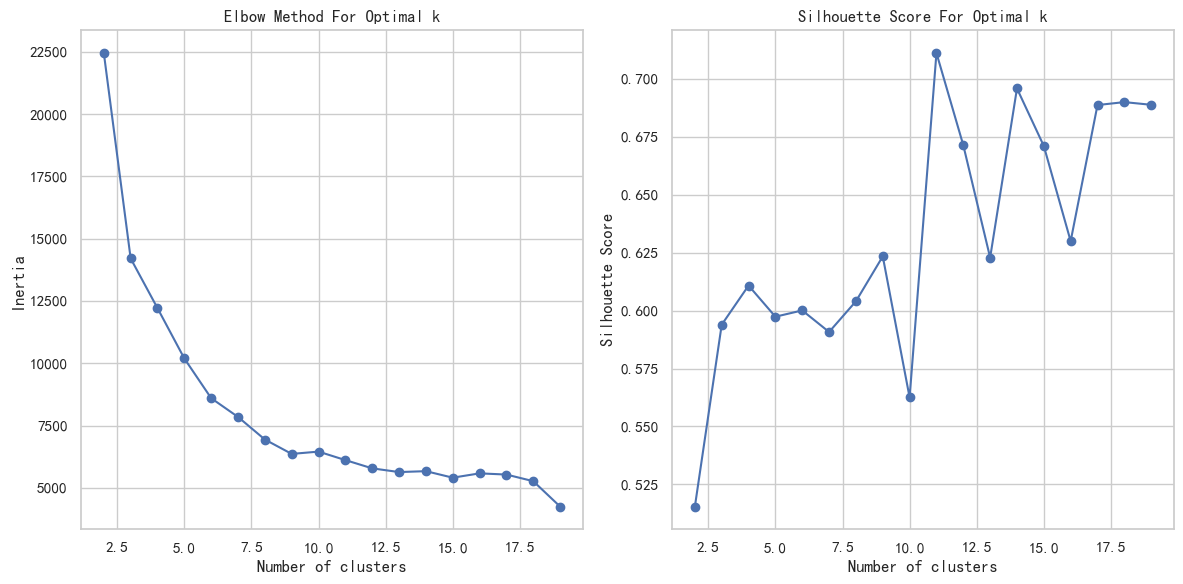

In [258]:
# 使用肘部法则确定最佳聚类数
inertia = []
silhouette_scores = []
K = range(2, 20)  # 减少迭代次数，增加步长
for k in K:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=200, max_iter=500, n_init=40)  # 使用 MiniBatchKMeans
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# 绘制肘部法则图
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')

# 绘制轮廓系数图
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')

plt.tight_layout()
plt.show()


In [254]:
# 选择合适的聚类数并进行K-means聚类
optimal_k = K[silhouette_scores.index(max(silhouette_scores))]
print(f'Optimal number of clusters: {optimal_k}')

kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, batch_size=500, max_iter=200, n_init=20) 
kmeans.fit(X_scaled)


Optimal number of clusters: 11


MiniBatchKMeans(batch_size=500, max_iter=200, n_clusters=11, n_init=20,
                random_state=42)

In [255]:
#  获取聚类标签
labels = kmeans.labels_
labels


array([5, 5, 5, ..., 8, 1, 1])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


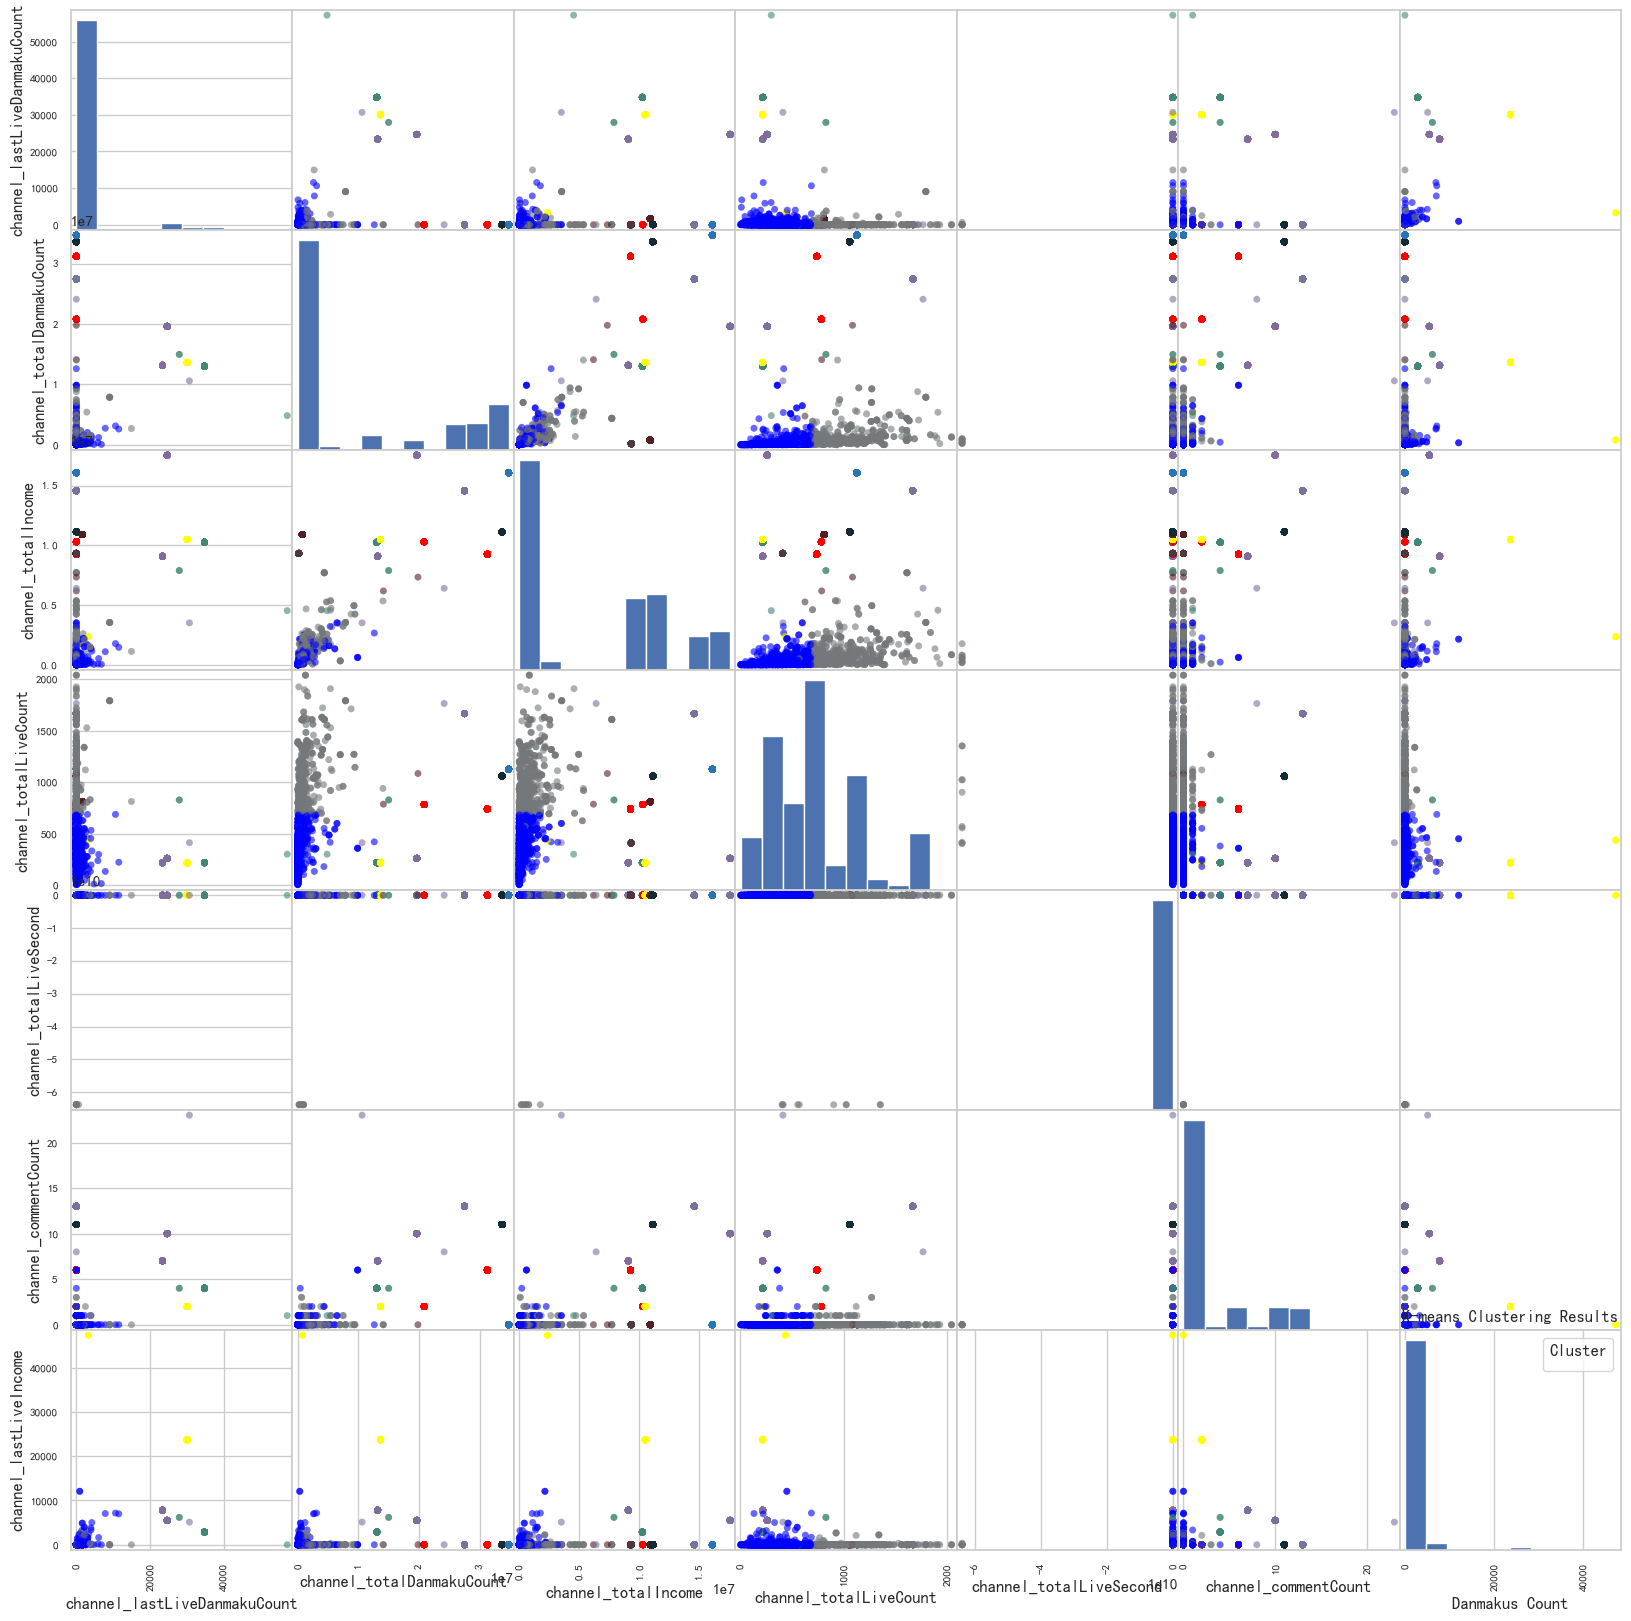

In [256]:
colors = np.array(['red', 'blue', 'yellow', '#541e24', '#4f383e', '#806d9e', '#74759b', '#2775b6', '#74787a', '#132c33', '#428675', '#5e665b', '#d2b116', '#f8e0b0', '#503e2a', '#fc8c23' ])
#  将聚类标签添加到原数据框中，但不保存到文件

X_df['cluster'] = labels  # 只给没有缺失值的行添加聚类标签

# 可视化聚类结果
# plt.figure(figsize=(10, 6))
pd.plotting.scatter_matrix(X, c=colors[X_df.cluster], figsize=(20,20), s=100, alpha =0.6)
# sns.pairplot(X, vars=features, palette='viridis', plot_kws={'alpha': 0.6})
# sns.scatterplot(x='danmakusCount', y='totalIncome', hue='cluster', data=sample_cdr, palette='viridis')
plt.title('K-means Clustering Results')
plt.xlabel('Danmakus Count')
plt.ylabel('Total Income')
plt.legend(title='Cluster')
plt.show()

In [259]:
print(X)

         channel_lastLiveDanmakuCount  channel_totalDanmakuCount   
1194920                         23373                   13161590  \
1194900                         23373                   13161590   
1194915                         23373                   13161590   
1194911                         23373                   13161590   
1194890                         23373                   13161590   
...                               ...                        ...   
1207379                             0                     343356   
130567                              0                      65264   
62078                               0                    2121471   
1392834                           795                     717178   
362751                              0                     280109   

         channel_totalIncome  channel_totalLiveCount  channel_totalLiveSecond   
1194920            9082166.0                     218                  1332311  \
1194900            90

## 聚类算法——DBSCAN

In [280]:
from sklearn.cluster import DBSCAN

# 调整 DBSCAN 参数
eps = 1  # 减小邻域半径
min_samples = 3  # 减小最小样本数

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(X_scaled)


DBSCAN(eps=1, min_samples=3)

In [281]:
# 获取聚类标签
labels_db = dbscan.labels_

X_df['cluster_db'] = labels_db  
X_df['cluster_db'].unique()


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, -1, 10, 11, 12],
      dtype=int64)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x600 with 0 Axes>

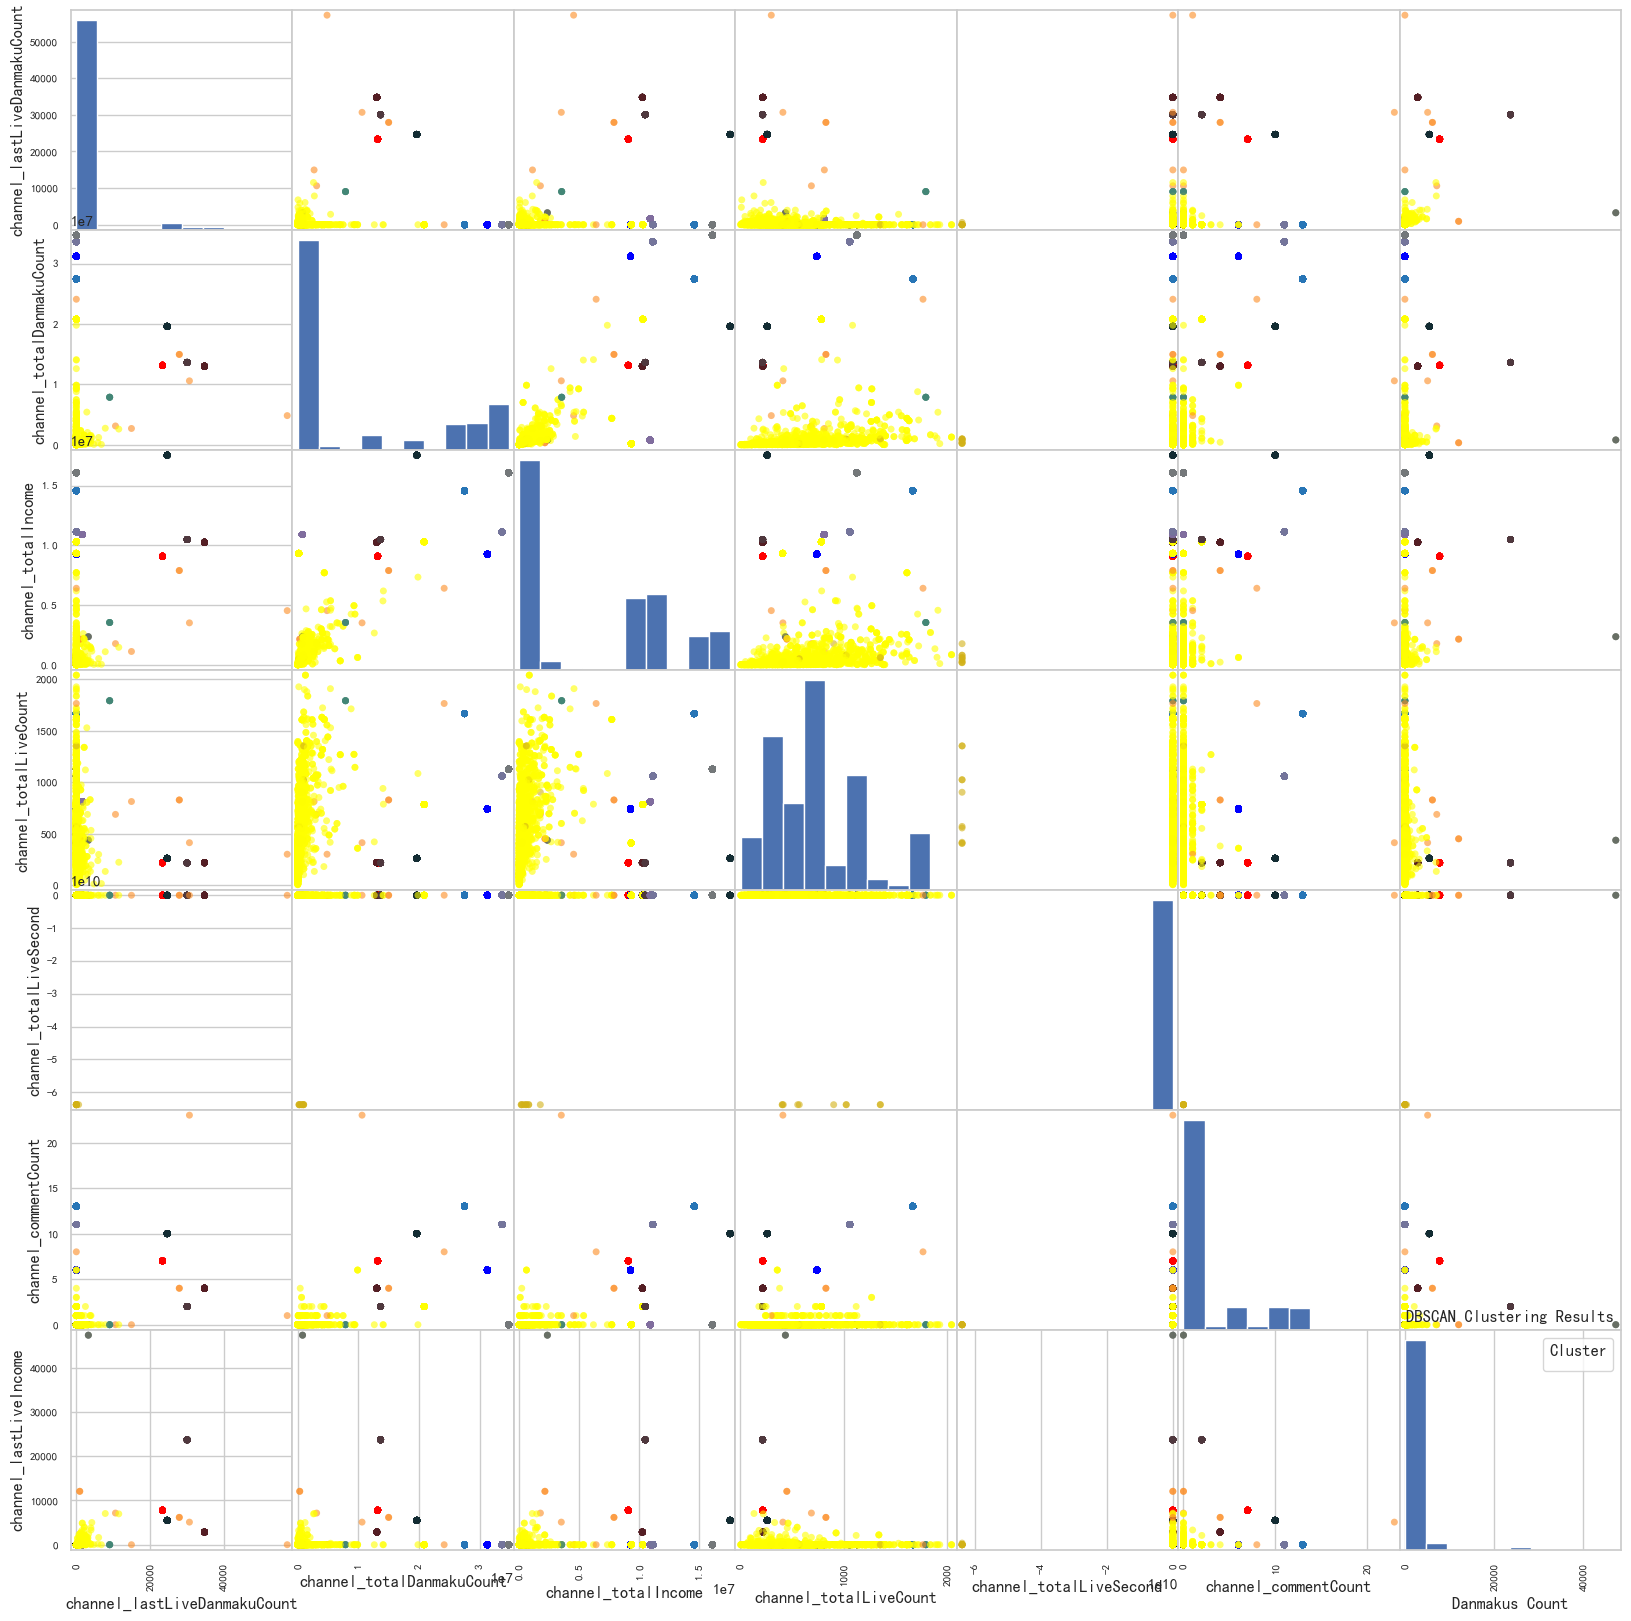

In [282]:
# 可视化聚类结果
plt.figure(figsize=(10, 6))
pd.plotting.scatter_matrix(X, c=colors[X_df.cluster_db], figsize=(20,20), s=100, alpha =0.6)
plt.title('DBSCAN Clustering Results')
plt.xlabel('Danmakus Count')
plt.ylabel('Total Income')
plt.legend(title='Cluster')
plt.show()



## 聚类算法——层次聚类

In [28]:
# from sklearn.cluster import AgglomerativeClustering

# # 选择用于聚类的字段（选择最重要的特征）
# features = [
#     'channel_totalDanmakuCount',
#     'channel_totalIncome',
#     'channel_totalLiveCount',
#     'channel_totalLiveSecond',
#     'channel_commentCount',
# ]

# # 提取特征数据
# X = sample_cdr[features].dropna()  # 去掉包含缺失值的行

# # 数据标准化
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # 使用层次聚类
# n_clusters = 4  # 聚类数

# hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
# hierarchical.fit(X_scaled)

# # 获取聚类标签
# labels = hierarchical.labels_

# # 将聚类标签添加到原数据框中
# sample_cdr['cluster'] = labels  # 只给没有缺失值的行添加聚类标签

# # 在Jupyter Notebook中展示结果
# # 展示前5行聚类结果
# print(sample_cdr.head())

# # 可视化聚类结果
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='danmakusCount', y='totalIncome', hue='cluster', data=sample_cdr, palette='viridis')
# plt.title('Hierarchical Clustering Results')
# plt.xlabel('Danmakus Count')
# plt.ylabel('Total Income')
# plt.legend(title='Cluster')
# plt.show()

## 关联分析

收入作为前项,先探讨总体收入


In [263]:
from sklearn.preprocessing import KBinsDiscretizer
import warnings
warnings.filterwarnings("ignore")
# 考虑用什么数值型字段，接着离散化成标签型
sample_cdr_rel = sample_cdr[['danmakusCount',
                            'startDate',
                            'stopDate',
                            'log_totalIncome',
                            'watchCount',
                            'likeCount',
                            'payCount',
                            'interactionCount',
                            'maxOnlineCount',
                            'channel_lastLiveDate',
                            'channel_lastLiveDanmakuCount',
                            'channel_totalDanmakuCount',
                            'channel_totalIncome',
                            'channel_totalLiveCount',
                            'channel_totalLiveSecond',
                            'channel_commentCount',
                            'channel_lastLiveIncome',
                            'hour'
]]

# 把不是int和float的变成int和float,用一个新的sample_cdr_rel_num存放
if sample_cdr_rel['hour'].dtypes == object:
    sample_cdr_rel['hour'] = sample_cdr_rel['hour'].astype(int) 

# 离散化数值型数据
discretizer = KBinsDiscretizer(n_bins=5, encode='onehot', strategy='kmeans')
sample_cdr_discretize = discretizer.fit_transform(sample_cdr_rel)

# 打印实际生成的每个特征的箱数
print("实际生成的每个特征的箱数: ", discretizer.n_bins_)

# 检查是否存在问题
for feature, bins in zip(sample_cdr_rel.columns, discretizer.n_bins_):
    if bins < 5:
        print(f"特征 {feature} 实际生成的箱数少于预期: {bins}")

# 将结果的稀疏矩阵转化成数组
sample_cdr_discretize_array = sample_cdr_discretize.toarray()

# 获取 one_hot编码后的列名
columns = []
for col in sample_cdr_rel.columns:
    for i in range(5):
        columns.append(f"{col} bin {i+1}")

# 创建编码后的dataframe
sample_cdr_discretize_df = pd.DataFrame(sample_cdr_discretize_array)


实际生成的每个特征的箱数:  [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


In [264]:

# 考虑添加离散型字段并二元化
sample_cdr_rel_other = sample_cdr['parentArea']
# 二元化这个字段
sample_cdr_rel_other_x = pd.get_dummies(sample_cdr_rel_other, columns=['parentArea'])
sample_cdr_rel_other_x = sample_cdr_rel_other_x.astype(float)
# 把
print(sample_cdr_rel_other_x)

         单机游戏   娱乐   手游  未知分区   生活   电台   知识   网游  虚拟主播
1194920   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0   1.0
1194900   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0   1.0
1194915   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0   1.0
1194911   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0   1.0
1194890   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0   1.0
...       ...  ...  ...   ...  ...  ...  ...  ...   ...
1207379   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0   1.0
130567    0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0   1.0
62078     0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0   1.0
1392834   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0   1.0
362751    0.0  0.0  0.0   0.0  0.0  1.0  0.0  0.0   0.0

[4872 rows x 9 columns]


In [265]:
# 把数值型的和离散型的编码之后拼在一起
sample_r = pd.concat([sample_cdr_discretize_df, sample_cdr_rel_other_x])

# 用0填充空值
sample_r = sample_r.fillna(0)

In [266]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth
frequent_itemsets = fpgrowth(sample_r, min_support=0.4, use_colnames=True)

# 打印频繁项集
print("Frequent Itemsets:")
print(frequent_itemsets)

# 根据频繁项集生成关联规则
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# 限制前项和后项的最大数量
max_antecedents = 3
max_consequents = 3

rules = rules[
    (rules['antecedents'].apply(lambda x: len(x)) <= max_antecedents) & 
    (rules['consequents'].apply(lambda x: len(x)) <= max_consequents)
]

# 打印生成的关联规则
print("\nAssociation Rules:")
print(rules)

Frequent Itemsets:
     support          itemsets
0   0.448173              (49)
1   0.441810              (30)
2   0.408970              (40)
3   0.421593              (25)
4   0.469007              (50)
5   0.467467              (80)
6   0.417898          (49, 50)
7   0.417488          (80, 49)
8   0.416872      (80, 49, 50)
9   0.422927          (50, 30)
10  0.421285          (80, 30)
11  0.420259      (80, 50, 30)
12  0.413280          (25, 30)
13  0.412664          (25, 50)
14  0.411125          (80, 25)
15  0.406096      (25, 50, 30)
16  0.409996      (80, 25, 50)
17  0.404454      (80, 25, 30)
18  0.403428  (80, 25, 50, 30)
19  0.466338          (80, 50)

Association Rules:
     antecedents   consequents  antecedent support  consequent support   
0           (49)          (50)            0.448173            0.469007  \
1           (50)          (49)            0.469007            0.448173   
2           (80)          (49)            0.467467            0.448173   
3           (4

收入作为后项，探讨单次收入

## 分类算法

In [286]:
sample_cdr_x = sample_cdr[[
    'parentArea', 
    'danmakusCount', 
    'watchCount', 
    'likeCount', 
    'payCount', 
    'interactionCount', 
    'maxOnlineCount', 
    'channel_lastLiveDanmakuCount', 
    'channel_totalDanmakuCount', 
    'channel_totalIncome', 
    'channel_totalLiveCount', 
    'channel_totalLiveSecond', 
    'channel_commentCount', 
    'channel_lastLiveIncome', 
    'hour_likeCount', 
    'hour_watchCount', 
    'totalIncome',  
    'hour'
]]
print(sample_cdr_x.head(1))
pd.options.mode.copy_on_write = True
sample_cdr_x['hour'] = sample_cdr_x['hour'].astype(float)
# sample_cdr_x['log_totalIncome'] = sample_cdr_x['log_totalIncome'].astype(int)
print(sample_cdr_x.dtypes)

        parentArea  danmakusCount  watchCount  likeCount  payCount   
1194920       虚拟主播          82143       58593      75582       336  \

         interactionCount  maxOnlineCount  channel_lastLiveDanmakuCount   
1194920              8260               0                         23373  \

         channel_totalDanmakuCount  channel_totalIncome   
1194920                   13161590            9082166.0  \

         channel_totalLiveCount  channel_totalLiveSecond   
1194920                     218                  1332311  \

         channel_commentCount  channel_lastLiveIncome  hour_likeCount   
1194920                     7                  7795.9    32951.963038  \

         hour_watchCount  totalIncome hour  
1194920     25545.161153      11806.0   19  
parentArea                       object
danmakusCount                     int64
watchCount                        int64
likeCount                         int64
payCount                          int64
interactionCount               

### 将parentArea二元化，并未接下来的分类算法做准备

In [287]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score ,roc_curve, auc
from sklearn.preprocessing import KBinsDiscretizer, label_binarize
from matplotlib.colors import ListedColormap
import warnings
from itertools import cycle

warnings.filterwarnings("ignore")

# 二元化parentArea列
sample_cdr_x = pd.get_dummies(sample_cdr_x, columns=['parentArea'])

classifiers = {
    'GaussianNB': GaussianNB(),
    'CRT': DecisionTreeClassifier(criterion='gini', random_state=42, max_depth=None),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'MLPClassifier': MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5)
}
# 定义训练和评估分类器的函数
def train_evaluate_classifier(_classifiers, variable_name, strategy='quantile'):
    for classifier_name, classifier in _classifiers.items():
        # 对目标变量进行等频分箱,先取对数再加一，用KBinsDiscretizer进行分箱
        sample_cdr_x[f'{variable_name}_bin'] = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy=strategy).fit_transform(sample_cdr_x[[variable_name]])
        print(sample_cdr_x[f'{variable_name}_bin'].sort_values().unique())
        _X = sample_cdr_x.drop([f'{variable_name}_bin', variable_name], axis=1)  # 特征变量
        _y = sample_cdr_x[f'{variable_name}_bin']  # 目标变量
        X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size=0.2, random_state=42)
        # 训练分类器
        classifier.fit(X_train, y_train)
        # 使用测试集进行预测
        y_pred = classifier.predict(X_test)
        # 计算准确率
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy of {classifier_name}:", accuracy)
        # 计算其他评估指标
        print(f"Classification report for {classifier_name}:")
        print(classification_report(y_test, y_pred))
        # 计算混淆矩阵并将其打印出来
        cm = confusion_matrix(y_test, y_pred)
        print(f"Confusion Matrix for {classifier_name}:")
        print(cm)
        
        # # 决定分箱数量，例如将值分为5个箱子
        # bins = 5

        # # 将混淆矩阵的值平展并通过np.percentile进行等频分箱
        # cm_flattened = cm.flatten()
        # percentiles = np.percentile(cm_flattened, np.arange(0, 100, 100/bins))

        # # 构建一个新的cm映射，值为其所在的箱子索引
        # cm_binned = np.digitize(cm, percentiles)

        # # 为分箱创建colormap，这里举例使用5个颜色
        # colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF']
        # custom_cmap = ListedColormap(colors[:bins])

        plt.figure(figsize=(10, 7))

        # 使用`cm_binned`和自定义colormap绘制混淆矩阵
        sns.heatmap(cm, annot=cm, fmt='d', cmap='Set3', linewidths=0.5, linecolor='black', square=True, annot_kws={'size': 16}, xticklabels=[f'{variable_name}_bin_0', f'{variable_name}_bin_1', f'{variable_name}_bin_2', f'{variable_name}_bin_3', f'{variable_name}_bin_4'], yticklabels=[f'{variable_name}_bin_0', f'{variable_name}_bin_1', f'{variable_name}_bin_2', f'{variable_name}_bin_3', f'{variable_name}_bin_4'])
        plt.title("Confusion Matrix with Equi-frequency Binning")
        plt.ylabel('Actual Class')
        plt.xlabel('Predicted Class')

        plt.show()
        # 计算 ROC AUC 分数
        n_classes = len(np.unique(y_test))

        # 首先需要将标签二值化
        y_test_binarized = label_binarize(y_test, classes=range(n_classes))

        # 获取每个类别的预测概率
        # 对于每个类，所需的预测概率是 "属于该类的概率"
        y_prob = classifier.predict_proba(X_test)

        # 计算每个类的ROC曲线和AUC值
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # 计算微平均ROC曲线和AUC值
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_prob.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # 为了计算宏平均ROC曲线和AUC值，先聚合所有FPRs
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # 再通过插值计算所有的ROC曲线在这一点上的TPR
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # 取平均值并计算AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        # 绘制所有的ROC曲线
        plt.figure()
        lw = 2
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                    label='ROC curve of class {0} (area = {1:0.2f})'
                    ''.format(i, roc_auc[i]))

        plt.plot(fpr["micro"], tpr["micro"],
                label='micro-average ROC curve (area = {0:0.2f})'
                    ''.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                label='macro-average ROC curve (area = {0:0.2f})'
                    ''.format(roc_auc["macro"]), color='navy', linestyle=':', linewidth=4)

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        plt.show()

### 把maxOnlineCount作为y

[0. 1. 2. 3. 4.]
Accuracy of GaussianNB: 0.6482051282051282
Classification report for GaussianNB:
              precision    recall  f1-score   support

         0.0       0.99      0.64      0.77       773
         1.0       0.34      0.89      0.49        90
         2.0       0.50      0.03      0.05        40
         3.0       0.10      0.86      0.18        22
         4.0       0.71      0.78      0.74        50

    accuracy                           0.65       975
   macro avg       0.53      0.64      0.45       975
weighted avg       0.87      0.65      0.70       975

Confusion Matrix for GaussianNB:
[[493 116   0 148  16]
 [  6  80   0   4   0]
 [  1  33   1   5   0]
 [  0   2   1  19   0]
 [  0   3   0   8  39]]


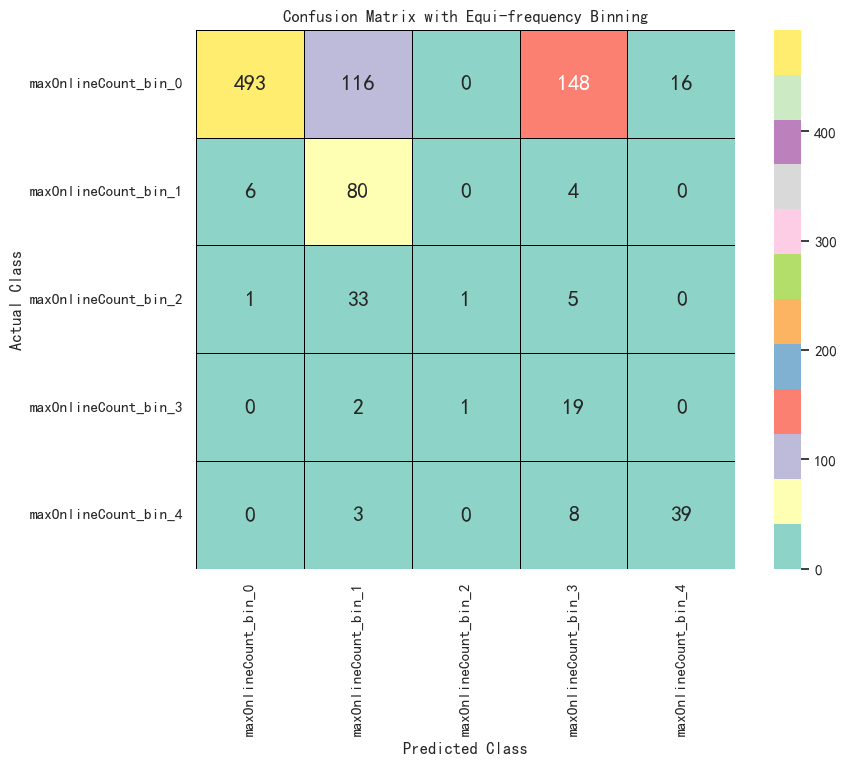

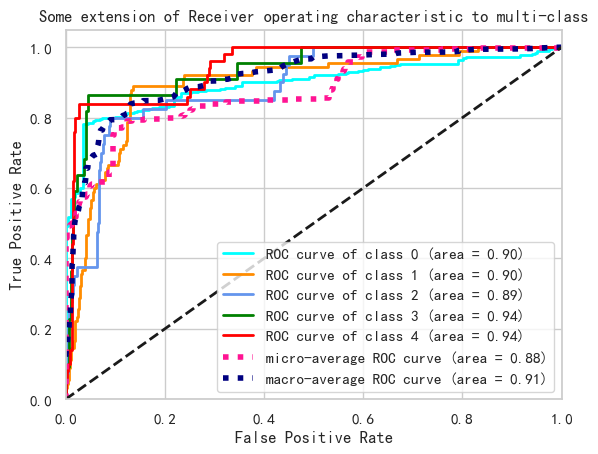

[0. 1. 2. 3. 4.]
Accuracy of CRT: 0.9025641025641026
Classification report for CRT:
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96       773
         1.0       0.73      0.68      0.71        90
         2.0       0.71      0.68      0.69        40
         3.0       0.55      0.55      0.55        22
         4.0       0.77      0.72      0.74        50

    accuracy                           0.90       975
   macro avg       0.74      0.72      0.73       975
weighted avg       0.90      0.90      0.90       975

Confusion Matrix for CRT:
[[744  15   2   4   8]
 [ 21  61   7   1   0]
 [  4   6  27   3   0]
 [  4   1   2  12   3]
 [ 12   0   0   2  36]]


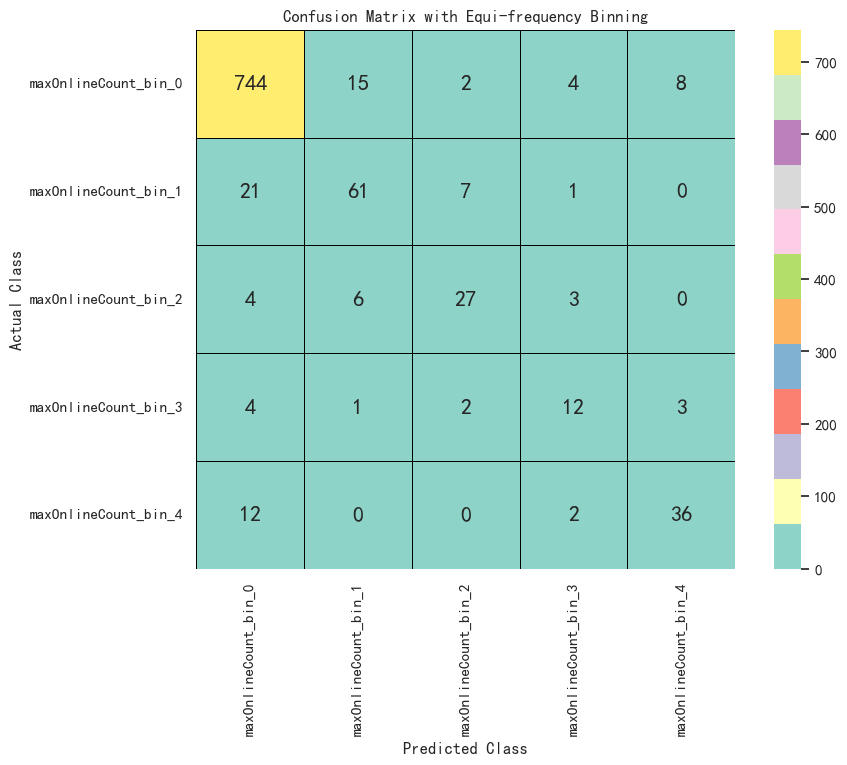

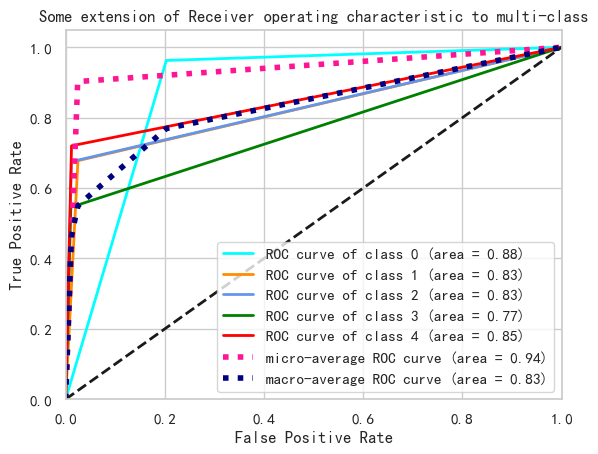

[0. 1. 2. 3. 4.]
Accuracy of LogisticRegression: 0.6851282051282052
Classification report for LogisticRegression:
              precision    recall  f1-score   support

         0.0       0.79      0.82      0.81       773
         1.0       0.00      0.00      0.00        90
         2.0       0.00      0.00      0.00        40
         3.0       0.00      0.00      0.00        22
         4.0       0.22      0.62      0.32        50

    accuracy                           0.69       975
   macro avg       0.20      0.29      0.23       975
weighted avg       0.64      0.69      0.66       975

Confusion Matrix for LogisticRegression:
[[637  24   2   0 110]
 [ 89   0   0   0   1]
 [ 39   1   0   0   0]
 [ 22   0   0   0   0]
 [ 17   2   0   0  31]]


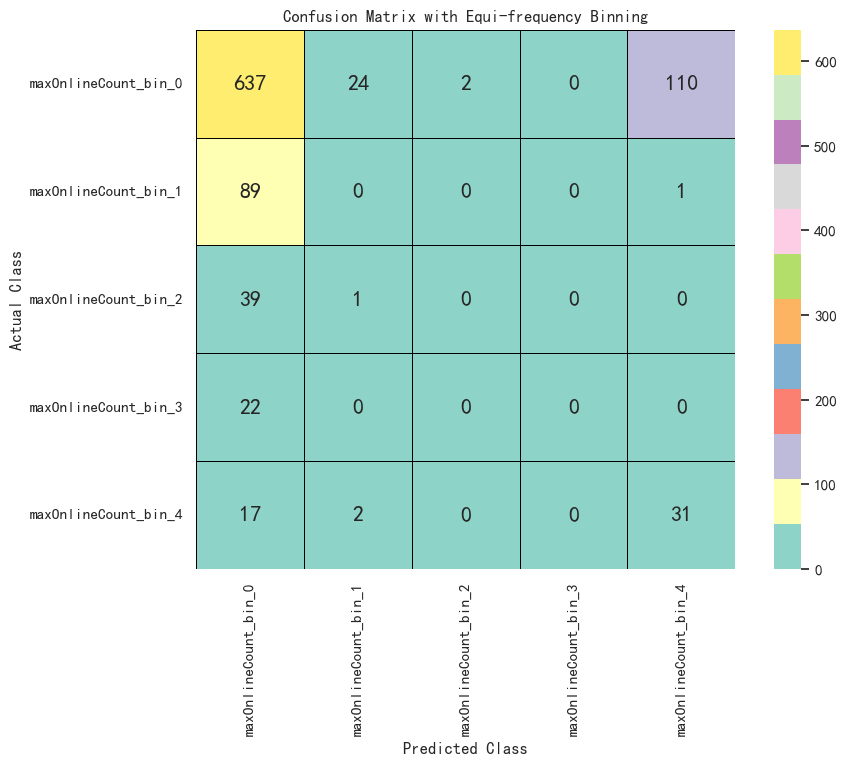

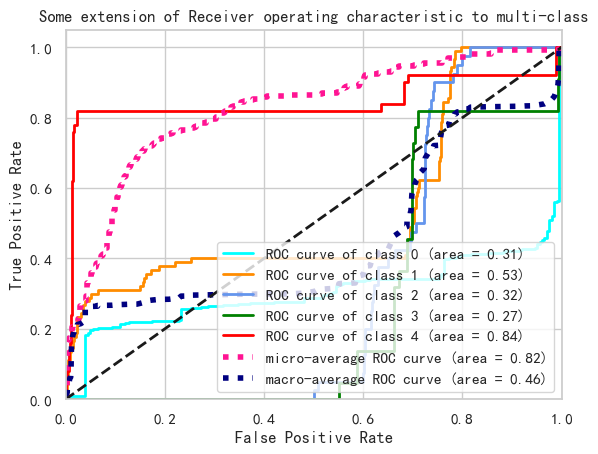

[0. 1. 2. 3. 4.]
Accuracy of MLPClassifier: 0.7948717948717948
Classification report for MLPClassifier:
              precision    recall  f1-score   support

         0.0       0.80      0.99      0.89       773
         1.0       0.00      0.00      0.00        90
         2.0       0.00      0.00      0.00        40
         3.0       0.00      0.00      0.00        22
         4.0       0.53      0.18      0.27        50

    accuracy                           0.79       975
   macro avg       0.27      0.23      0.23       975
weighted avg       0.66      0.79      0.72       975

Confusion Matrix for MLPClassifier:
[[766   2   0   0   5]
 [ 89   0   0   0   1]
 [ 39   1   0   0   0]
 [ 19   0   1   0   2]
 [ 41   0   0   0   9]]


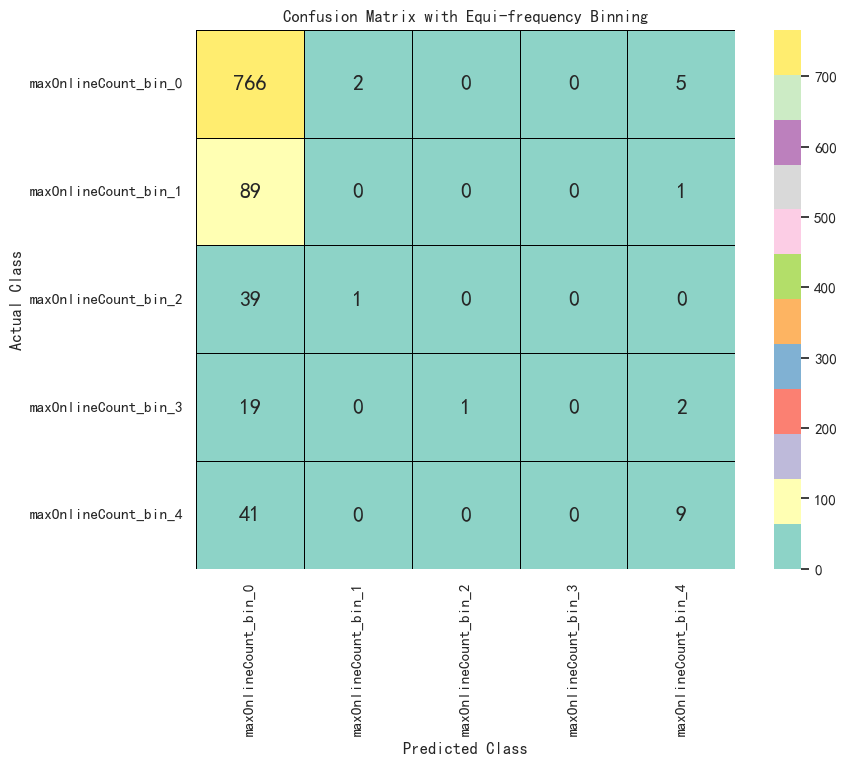

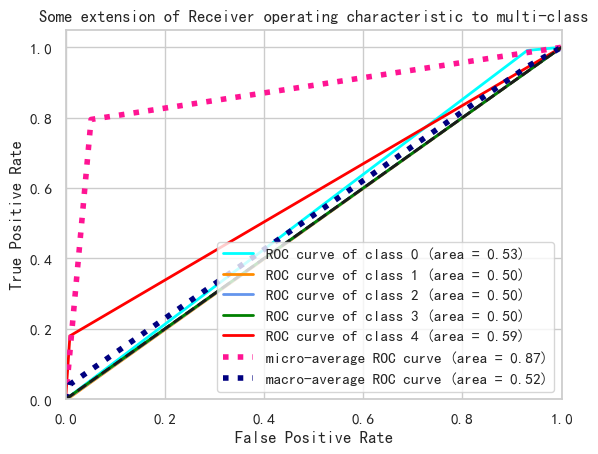

[0. 1. 2. 3. 4.]
Accuracy of RandomForestClassifier: 0.9323076923076923
Classification report for RandomForestClassifier:
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       773
         1.0       0.82      0.64      0.72        90
         2.0       0.78      0.80      0.79        40
         3.0       0.75      0.68      0.71        22
         4.0       0.91      0.86      0.89        50

    accuracy                           0.93       975
   macro avg       0.84      0.79      0.82       975
weighted avg       0.93      0.93      0.93       975

Confusion Matrix for RandomForestClassifier:
[[761   7   1   1   3]
 [ 27  58   5   0   0]
 [  1   6  32   1   0]
 [  3   0   3  15   1]
 [  4   0   0   3  43]]


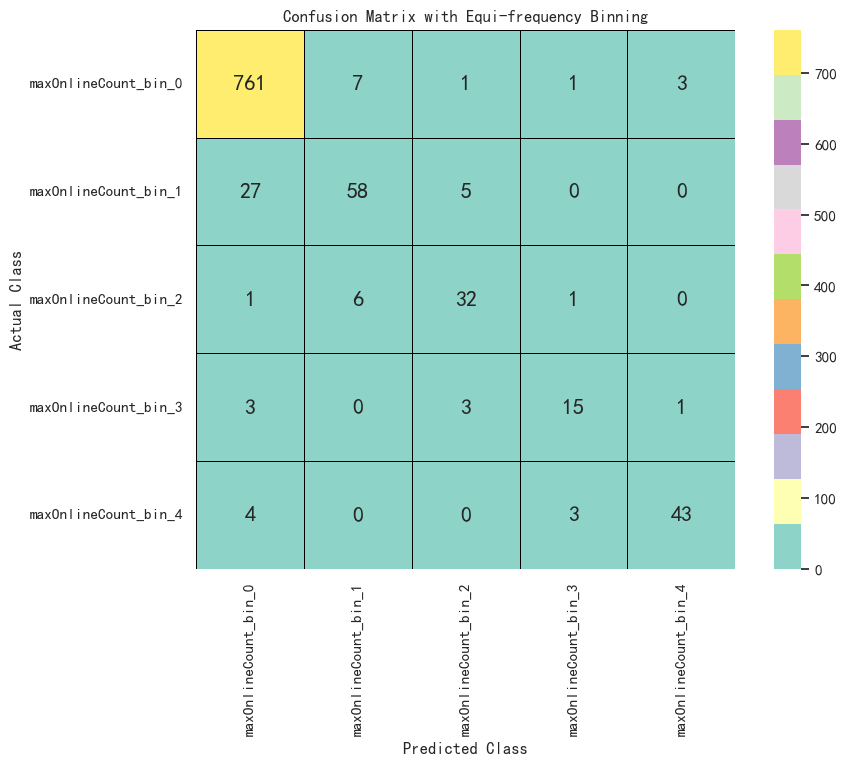

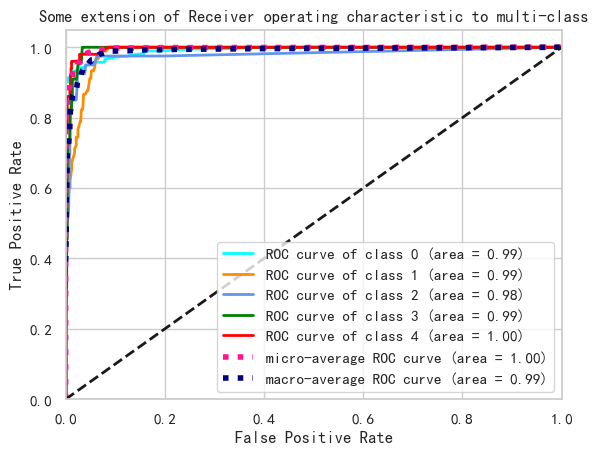

[0. 1. 2. 3. 4.]
Accuracy of KNeighborsClassifier: 0.9138461538461539
Classification report for KNeighborsClassifier:
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96       773
         1.0       0.81      0.61      0.70        90
         2.0       0.63      0.65      0.64        40
         3.0       0.57      0.59      0.58        22
         4.0       0.89      0.80      0.84        50

    accuracy                           0.91       975
   macro avg       0.77      0.73      0.74       975
weighted avg       0.91      0.91      0.91       975

Confusion Matrix for KNeighborsClassifier:
[[757   7   3   3   3]
 [ 27  55   8   0   0]
 [  7   5  26   2   0]
 [  2   1   4  13   2]
 [  5   0   0   5  40]]


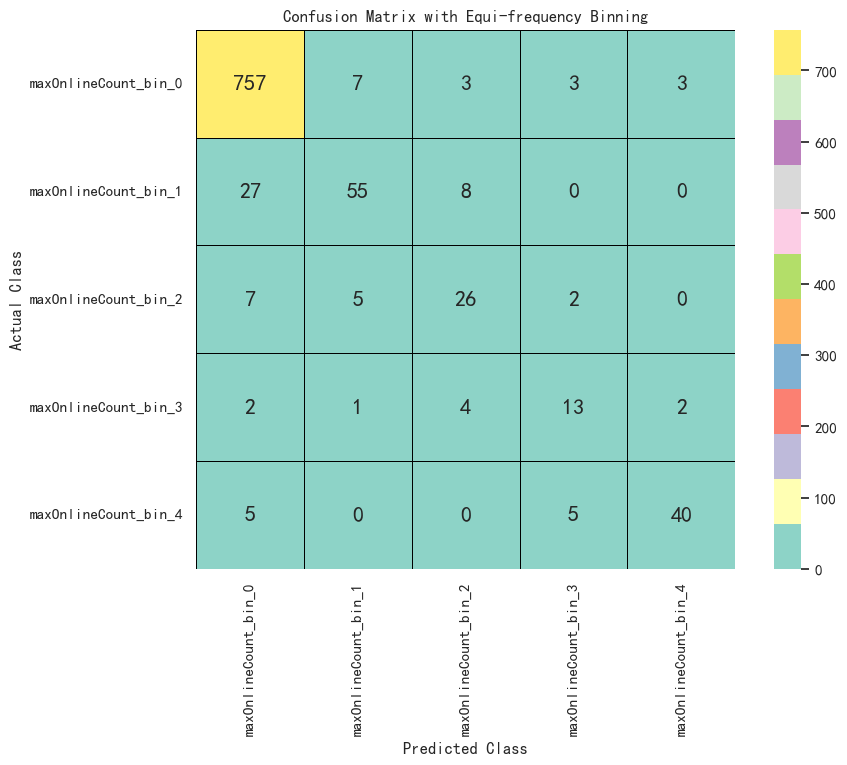

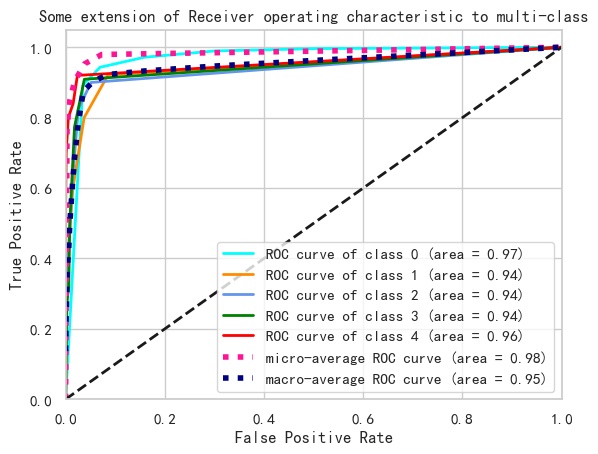

In [288]:
train_evaluate_classifier(classifiers, 'maxOnlineCount', strategy='kmeans')

### 把totalIncome作为y

[0. 1. 2. 3. 4.]
Accuracy of GaussianNB: 0.5087179487179487
Classification report for GaussianNB:
              precision    recall  f1-score   support

         0.0       0.99      0.59      0.74       786
         1.0       0.00      0.00      0.00       145
         2.0       0.06      0.94      0.11        32
         3.0       0.00      0.00      0.00        10
         4.0       0.00      0.00      0.00         2

    accuracy                           0.51       975
   macro avg       0.21      0.31      0.17       975
weighted avg       0.80      0.51      0.60       975

Confusion Matrix for GaussianNB:
[[466   0 319   0   1]
 [  5   0 140   0   0]
 [  1   0  30   0   1]
 [  0   0  10   0   0]
 [  0   0   2   0   0]]


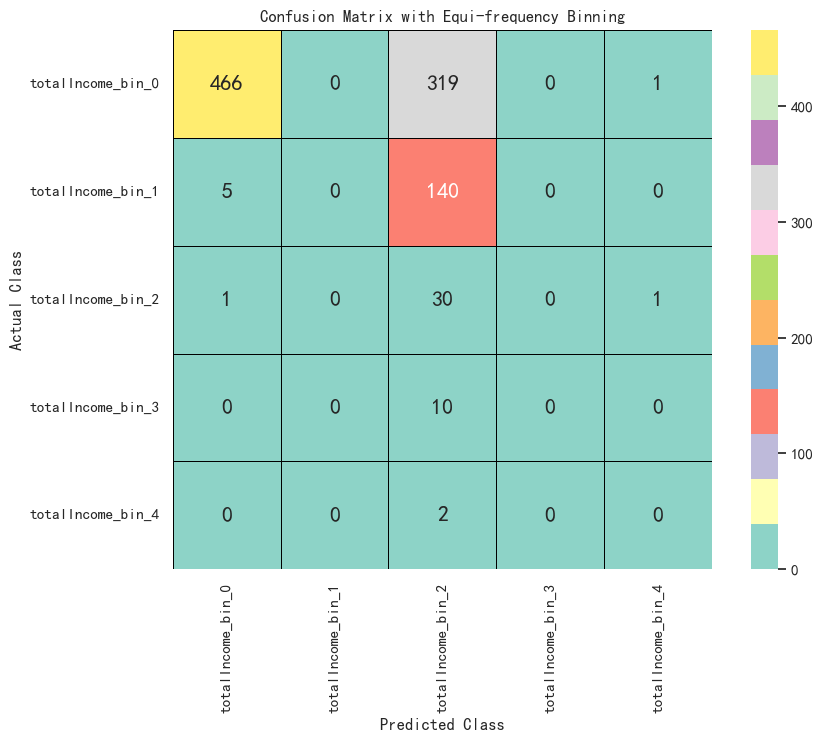

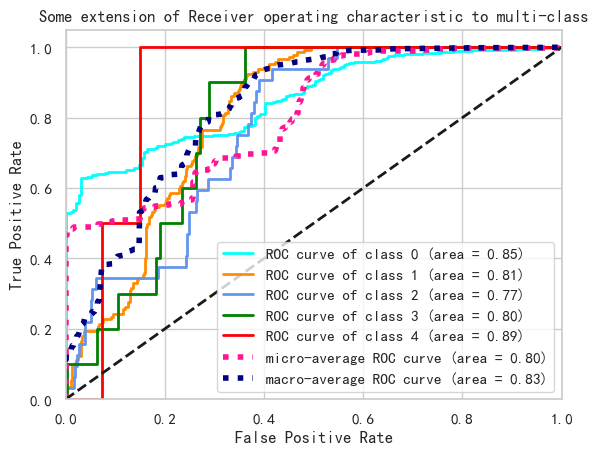

[0. 1. 2. 3. 4.]
Accuracy of CRT: 0.8205128205128205
Classification report for CRT:
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91       786
         1.0       0.54      0.49      0.51       145
         2.0       0.21      0.28      0.24        32
         3.0       0.12      0.10      0.11        10
         4.0       0.00      0.00      0.00         2

    accuracy                           0.82       975
   macro avg       0.36      0.36      0.36       975
weighted avg       0.82      0.82      0.82       975

Confusion Matrix for CRT:
[[719  48  16   2   1]
 [ 60  71  14   0   0]
 [  9  10   9   3   1]
 [  2   3   4   1   0]
 [  0   0   0   2   0]]


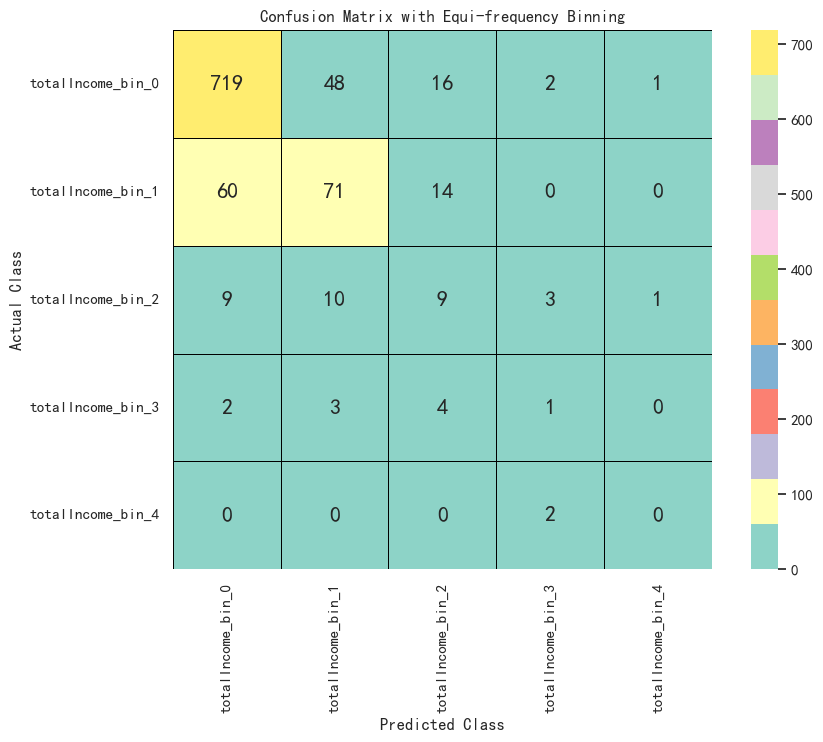

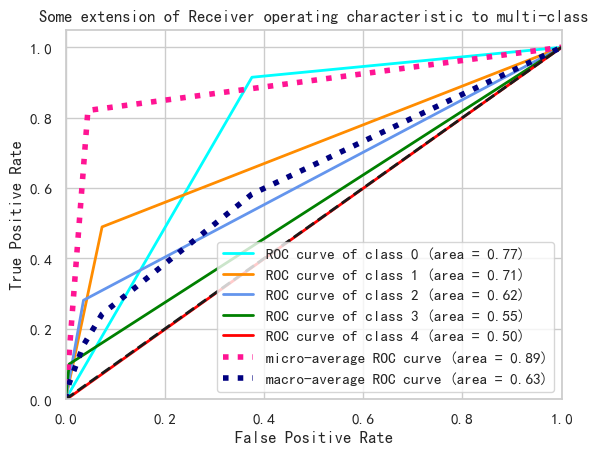

[0. 1. 2. 3. 4.]
Accuracy of LogisticRegression: 0.718974358974359
Classification report for LogisticRegression:
              precision    recall  f1-score   support

         0.0       0.79      0.89      0.84       786
         1.0       0.00      0.00      0.00       145
         2.0       0.00      0.00      0.00        32
         3.0       0.00      0.00      0.00        10
         4.0       0.00      0.00      0.00         2

    accuracy                           0.72       975
   macro avg       0.16      0.18      0.17       975
weighted avg       0.63      0.72      0.67       975

Confusion Matrix for LogisticRegression:
[[701  55   2   0  28]
 [145   0   0   0   0]
 [ 32   0   0   0   0]
 [ 10   0   0   0   0]
 [  2   0   0   0   0]]


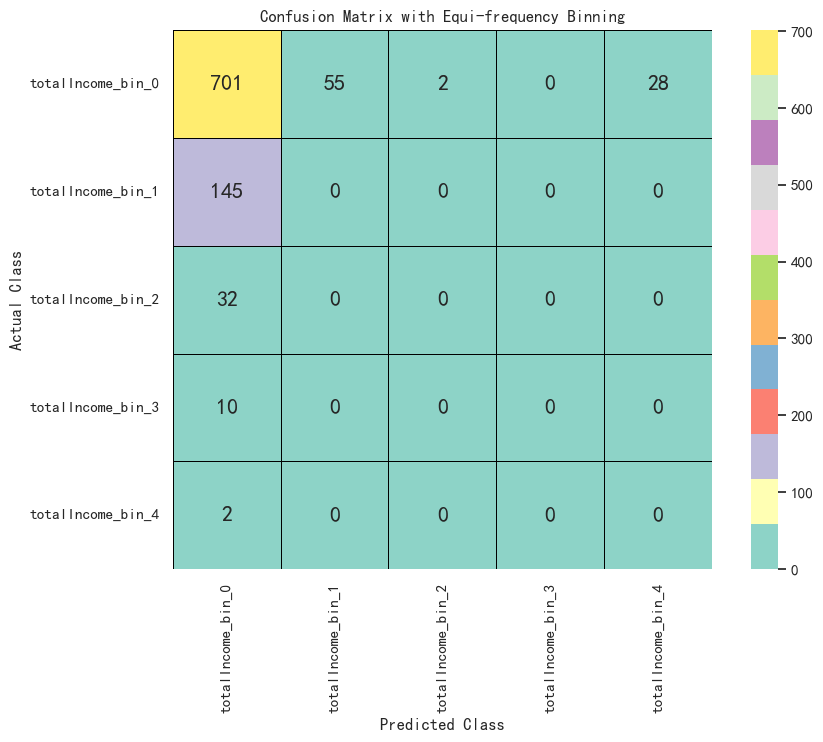

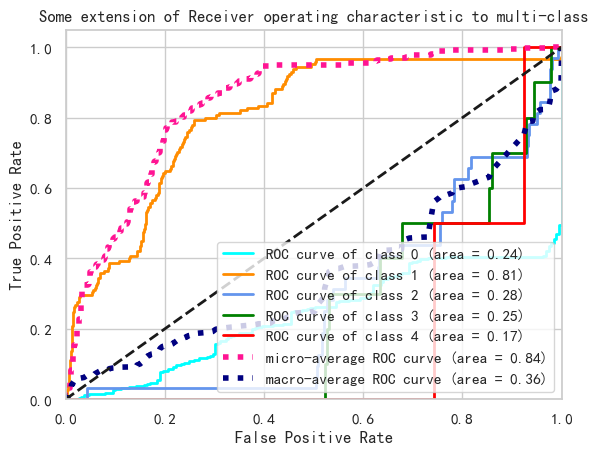

[0. 1. 2. 3. 4.]
Accuracy of MLPClassifier: 0.8276923076923077
Classification report for MLPClassifier:
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91       786
         1.0       0.53      0.32      0.40       145
         2.0       1.00      0.03      0.06        32
         3.0       0.00      0.00      0.00        10
         4.0       0.00      0.00      0.00         2

    accuracy                           0.83       975
   macro avg       0.48      0.26      0.27       975
weighted avg       0.80      0.83      0.79       975

Confusion Matrix for MLPClassifier:
[[759  26   0   0   1]
 [ 98  47   0   0   0]
 [ 18  12   1   0   1]
 [  7   3   0   0   0]
 [  1   1   0   0   0]]


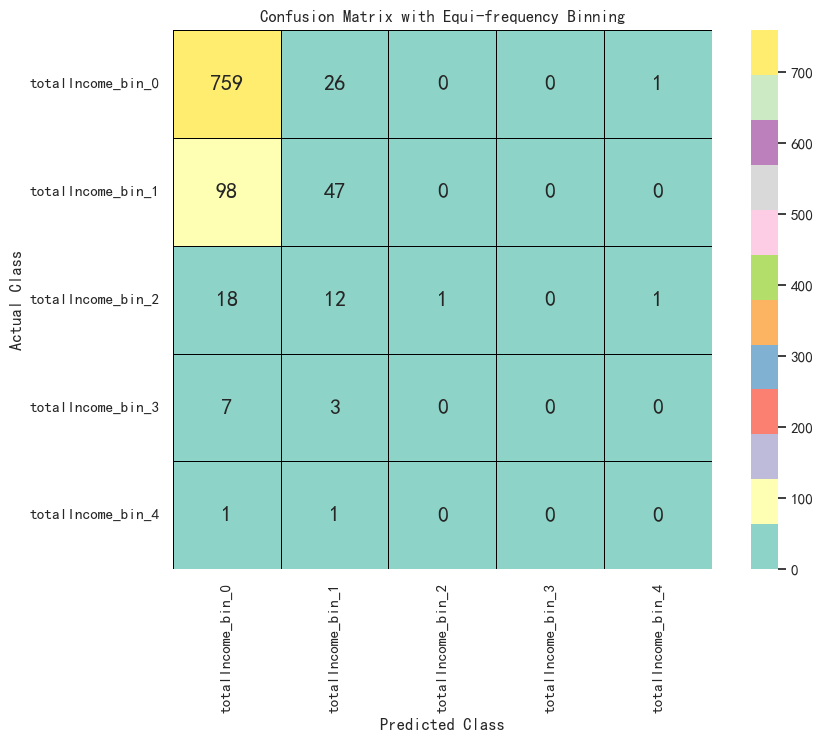

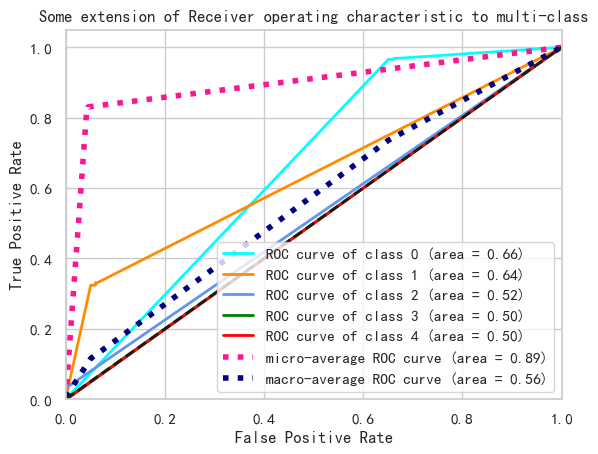

[0. 1. 2. 3. 4.]
Accuracy of RandomForestClassifier: 0.8533333333333334
Classification report for RandomForestClassifier:
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.93       786
         1.0       0.56      0.57      0.56       145
         2.0       0.27      0.09      0.14        32
         3.0       0.25      0.10      0.14        10
         4.0       0.00      0.00      0.00         2

    accuracy                           0.85       975
   macro avg       0.40      0.34      0.36       975
weighted avg       0.83      0.85      0.84       975

Confusion Matrix for RandomForestClassifier:
[[746  36   4   0   0]
 [ 62  82   1   0   0]
 [  6  21   3   2   0]
 [  0   6   3   1   0]
 [  0   1   0   1   0]]


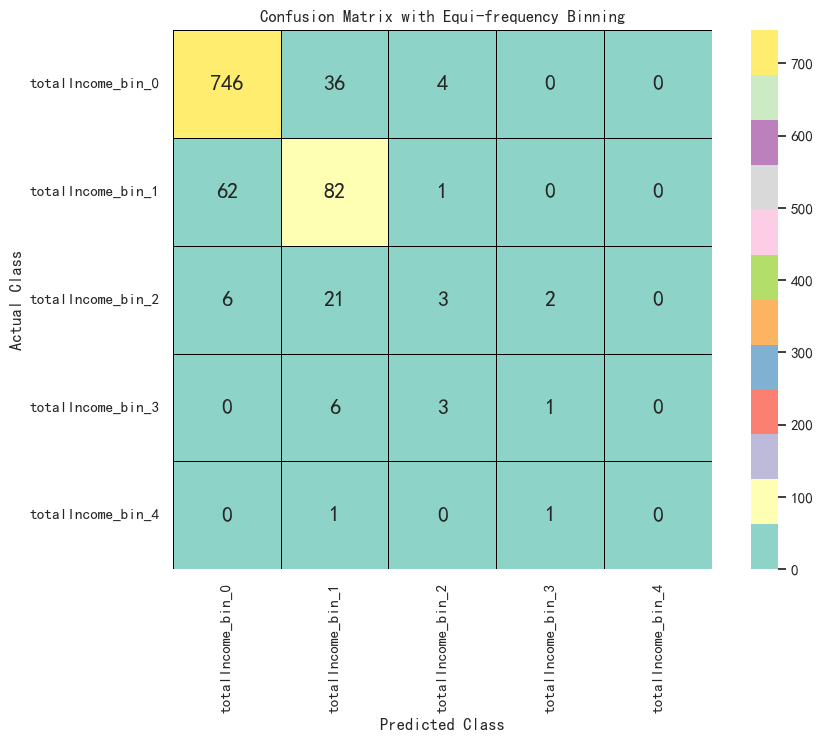

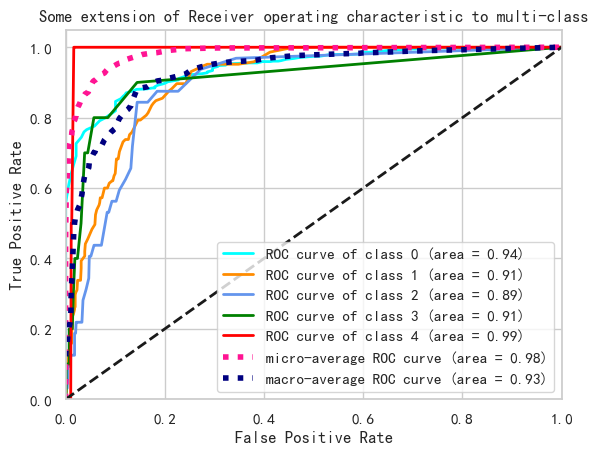

[0. 1. 2. 3. 4.]
Accuracy of KNeighborsClassifier: 0.8297435897435897
Classification report for KNeighborsClassifier:
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92       786
         1.0       0.50      0.45      0.47       145
         2.0       0.09      0.03      0.05        32
         3.0       0.00      0.00      0.00        10
         4.0       0.00      0.00      0.00         2

    accuracy                           0.83       975
   macro avg       0.30      0.28      0.29       975
weighted avg       0.80      0.83      0.81       975

Confusion Matrix for KNeighborsClassifier:
[[743  42   1   0   0]
 [ 72  65   8   0   0]
 [ 14  16   1   1   0]
 [  5   4   1   0   0]
 [  0   2   0   0   0]]


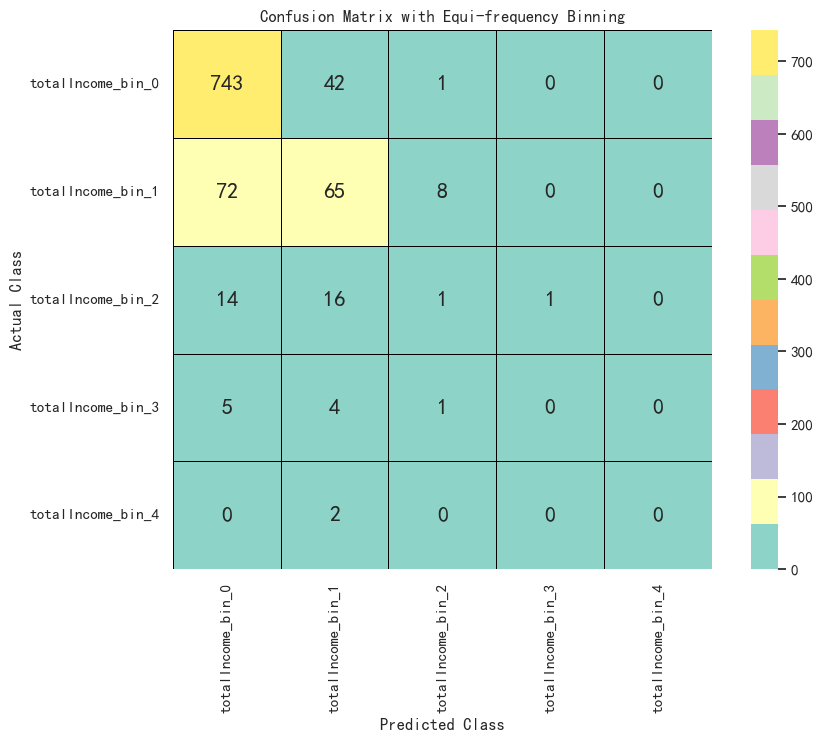

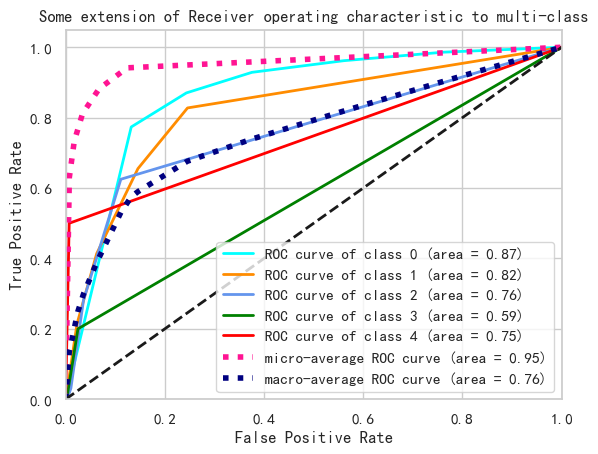

In [289]:
train_evaluate_classifier(classifiers, 'totalIncome', strategy='kmeans')

In [290]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
# 数据预处理 - cut
# sample_cdr_x['income_bin'] = pd.cut(sample_cdr_x['totalIncome'], 5, labels=False)
# X = sample_cdr_x.drop(['totalIncome', 'income_bin'], axis=1)
# y = sample_cdr_x['income_bin']

# KBins
def nn_train(sample_cdr_x, variable_name, strategy='kmeans'):
    # 对目标变量进行等频分箱,先取对数再加一，用KBinsDiscretizer进行分箱
    sample_cdr_x[f'{variable_name}_bin'] = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy=strategy).fit_transform(sample_cdr_x[[variable_name]])
    print(sample_cdr_x[f'{variable_name}_bin'].sort_values().unique())
    _X = sample_cdr_x.drop([f'{variable_name}_bin', variable_name], axis=1)  # 特征变量
    _y = sample_cdr_x[f'{variable_name}_bin']  # 目标变量
    X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    num_classes = len(np.unique(_y))
    print(f"Number of classes: {num_classes}")
    # 标签独热编码
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_test = to_categorical(y_test, num_classes=num_classes)

    # 构建模型
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # 编译模型
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            predictions = model(x, training=True)
            loss = tf.keras.losses.categorical_crossentropy(y, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    # 训练模型
    optimizer = tf.keras.optimizers.Adam()
    epochs = 100
    batch_size = 64

    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            x_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            loss = train_step(x_batch, y_batch)
        
        if epoch % 10 == 0:
            train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
            val_loss, val_accuracy = model.evaluate(X_test, y_test, verbose=0)
            print(f'Epoch {epoch}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

    # 评估模型
    y_pred = model.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)
    y_test_classes = y_test.argmax(axis=1)

    # 混淆矩阵
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    print(cm)
    print(classification_report(y_test_classes, y_pred_classes))
    # 标签二值化
    y_test_binarized = label_binarize(y_test_classes, classes=range(num_classes))

    # 获取每个类别的预测概率
    y_pred_prob = model.predict(X_test)

    # 计算每个类的ROC曲线和AUC值
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 微平均 - 计算所有FP和所有TP
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # 宏平均 - 计算所有类别的平均FPR, TPR
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # 绘制所有ROC曲线
    plt.figure(figsize=(8, 6))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

[0. 1. 2. 3. 4.]
Number of classes: 5
Epoch 0, Train Loss: 0.15402387082576752, Train Accuracy: 0.9524703025817871, Validation Loss: 0.15245318412780762, Validation Accuracy: 0.9527864456176758
Epoch 10, Train Loss: 0.1521957814693451, Train Accuracy: 0.9522481560707092, Validation Loss: 0.15079638361930847, Validation Accuracy: 0.9526292681694031
Epoch 20, Train Loss: 0.15055374801158905, Train Accuracy: 0.952049970626831, Validation Loss: 0.14912815392017365, Validation Accuracy: 0.9525130987167358
Epoch 30, Train Loss: 0.15303261578083038, Train Accuracy: 0.9520414471626282, Validation Loss: 0.15048488974571228, Validation Accuracy: 0.952403724193573
Epoch 40, Train Loss: 0.1543864756822586, Train Accuracy: 0.9517834186553955, Validation Loss: 0.15212467312812805, Validation Accuracy: 0.9520483613014221
Epoch 50, Train Loss: 0.1530199646949768, Train Accuracy: 0.9516040086746216, Validation Loss: 0.15342122316360474, Validation Accuracy: 0.9519868493080139
Epoch 60, Train Loss: 0.15

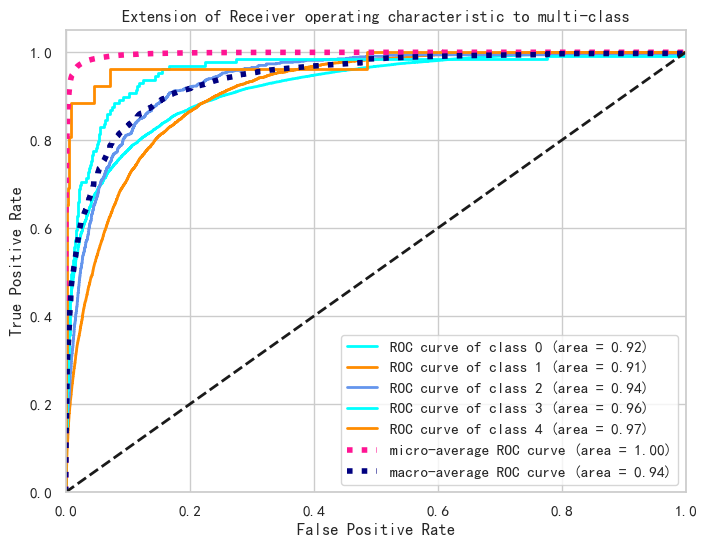

In [292]:
sample_income = cdr[['totalIncome', 'live_time_last', 'danmakusCount', 'likeCount', 'maxOnlineCount', 'channel_totalIncome', 'channel_totalLiveCount', 'channel_lastLiveIncome', 'hour_likeCount', 'hour_watchCount']]
nn_train(sample_income, 'totalIncome')

[0. 1. 2. 3. 4.]
Number of classes: 5
Epoch 0, Train Loss: 1.3833740949630737, Train Accuracy: 0.8119065761566162, Validation Loss: 1.3869788646697998, Validation Accuracy: 0.782564103603363
Epoch 10, Train Loss: 0.3057054281234741, Train Accuracy: 0.9012060761451721, Validation Loss: 0.33993425965309143, Validation Accuracy: 0.8820512890815735
Epoch 20, Train Loss: 0.23431622982025146, Train Accuracy: 0.9119835495948792, Validation Loss: 0.276396244764328, Validation Accuracy: 0.9035897254943848
Epoch 30, Train Loss: 0.20848354697227478, Train Accuracy: 0.9196817874908447, Validation Loss: 0.2458830028772354, Validation Accuracy: 0.9128205180168152
Epoch 40, Train Loss: 0.20994271337985992, Train Accuracy: 0.9178855419158936, Validation Loss: 0.2558046877384186, Validation Accuracy: 0.9066666960716248
Epoch 50, Train Loss: 0.18715354800224304, Train Accuracy: 0.9222478866577148, Validation Loss: 0.22685325145721436, Validation Accuracy: 0.9138461351394653
Epoch 60, Train Loss: 0.18695

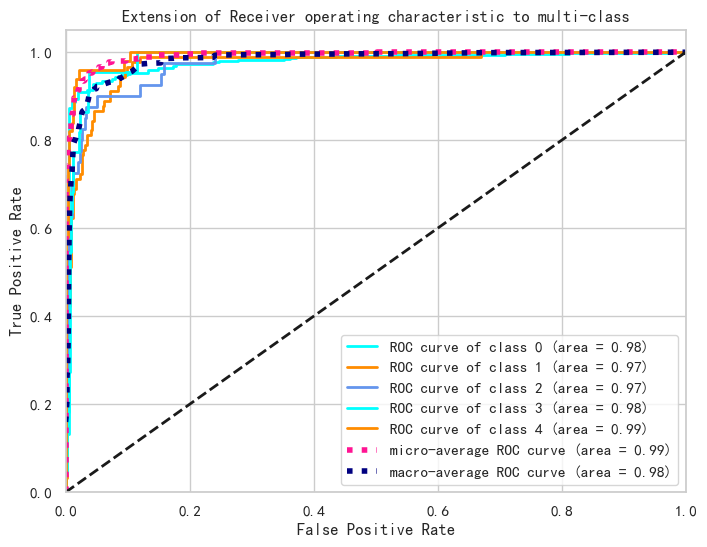

In [293]:
sample_maxonline = sample_cdr[['totalIncome', 'live_time_last', 'danmakusCount', 'likeCount', 'maxOnlineCount', 'channel_totalIncome', 'channel_totalLiveCount', 'channel_lastLiveIncome', 'hour_likeCount', 'hour_watchCount']]
nn_train(sample_maxonline, 'maxOnlineCount')